# Testing GOAT
Pranav Mathur

In [1]:
import numpy as np
from numpy.polynomial import chebyshev
import matplotlib.pyplot as plt
from goat_optimization import run_goat_optimization
from qutip_gate_simulation import data_from_tstep, simulate_gate, calculate_fidelity
from scipy.optimize import NonlinearConstraint

## Rydberg Gates

In [2]:
# define hamiltonians
H0 = np.zeros((4, 4))

H_plus = np.array([[0, 0, 1/2, 0],
                   [0, 0, 0, np.sqrt(2)/2],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0]])
H_minus = np.array([[0, 0, 0, 0],
                    [0, 0, 0, 0],
                    [1/2, 0, 0, 0],
                    [0, np.sqrt(2)/2, 0, 0]])
H_controls = [H_plus, H_minus]

U_target = np.array([[1, 0],
                     [0, -1]])

In [3]:
# define control functions
def to_control_func_plus(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    return control_extra_params["Omega_max"] * np.exp(1j * alpha[j])

def to_control_func_minus(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    return control_extra_params["Omega_max"] * np.exp(-1j * alpha[j])

def to_control_param_derivs(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    deriv_matrix = np.zeros((2, alpha.size), dtype=complex)
    deriv_matrix[0][j] = 1j * control_extra_params["Omega_max"] * np.exp(1j * alpha[j])
    deriv_matrix[1][j] = -1j * control_extra_params["Omega_max"] * np.exp(-1j * alpha[j])
    return deriv_matrix

def chebyshev_control_func_plus(t, alpha, control_extra_params=None):
    return control_extra_params["Omega_max"] * np.exp( 1j * chebyshev.chebval( (2/control_extra_params["t_max"])*t-1, alpha) )

def chebyshev_control_func_minus(t, alpha, control_extra_params=None):
    return control_extra_params["Omega_max"] * np.exp( -1j * chebyshev.chebval( (2/control_extra_params["t_max"])*t-1, alpha) )

def chebyshev_control_param_derivs(t, alpha, control_extra_params=None):
    deriv_matrix = np.zeros((2, alpha.size), dtype=complex)
    phase = chebyshev.chebval((2/control_extra_params["t_max"])*t-1, alpha)
    plus_exp_val = 1j * control_extra_params["Omega_max"] * np.exp(1j * phase)
    minus_exp_val = -1j * control_extra_params["Omega_max"] * np.exp(-1j * phase)
    for i in range(alpha.size):
        c = np.zeros(alpha.size)
        c[i] = 1
        deriv_matrix[0][i] = plus_exp_val * chebyshev.chebval((2/control_extra_params["t_max"])*t-1, c)
        deriv_matrix[1][i] = minus_exp_val * chebyshev.chebval((2/control_extra_params["t_max"])*t-1, c)
    return deriv_matrix

# control_funcs = [to_control_func_plus, to_control_func_minus]
# control_param_derivs = to_control_param_derivs
control_funcs = [chebyshev_control_func_plus, chebyshev_control_func_minus]
control_param_derivs = chebyshev_control_param_derivs

def U_truncator(U_full):
    if U_full.ndim == 2:
        return U_full[0:2, 0:2]
    else:
        return U_full[:, 0:2, 0:2]

In [4]:
# initial values of piecewise controls
def load_pulse_profile_from_csv(filename):
    gate_parameters = np.genfromtxt(filename, delimiter=',', skip_header=1, filling_values=np.nan)
    t_min = gate_parameters[0, 0]
    t_max = gate_parameters[-2, 0]
    t_steps = gate_parameters[:-1, 0]
    drive_strengths = gate_parameters[:-1, 1]
    phases = gate_parameters[:-1, 2]

    return t_min, t_max, t_steps, drive_strengths, phases

t_min, t_max, t_steps, drive_strengths, phases = load_pulse_profile_from_csv("./pulses/01_cz.csv")
t_span = [t_min, t_max]
n_pieces = phases.size
alpha0 = np.concatenate((phases, [0]))

# custom initial values

# t_max = 7.612 # from TO gates paper
# n_pieces = 100
# t_span = [0, t_max]

# # alpha0 = np.random.uniform(low=np.pi/2, high=(3/2)*np.pi, size=n_pieces+1)
# alpha0 = 0.3 * np.ones(n_pieces + 1) 
# # alpha0 = np.zeros(n_pieces + 1)
# # alpha0 = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=n_pieces+1)

# alpha_bounds = np.tile([0, 2*np.pi], (n_pieces + 1, 1)) 
alpha_bounds = np.tile([-np.pi, np.pi], (n_pieces + 1, 1)) 

In [42]:
# initial values of chebyshev controls
t_min = 0
t_max = 7.612 # from TO gates paper TODO: try lower gate time
t_span = [t_min, t_max]

n_cheb_polys = 75
alpha0 = np.zeros(n_cheb_polys + 1)
alpha0[3] = 1

In [43]:
# control extra parameters and callback functions
control_extra_params = {
    "Omega_max": 1,
    "t_max": t_max,
    # "n_pieces": n_pieces
}

# approximate maximum of chebyshev series
def chebyshev_max(coeffs):
    N = coeffs.size - 1
    K = 4 * N
    x = np.cos(np.pi * np.arange(K+1) / K) # chebyshev points
    f = chebyshev.chebval(x, coeffs)
    return np.max(f)    
chebyshev_constraint = NonlinearConstraint(chebyshev_max, -np.pi, np.pi)

prev_params = []
def callback(x):
    prev_params.append(np.copy(x))

In [44]:
# import cProfile
# import pstats

# profiler = cProfile.Profile()
# profiler.enable()

res = run_goat_optimization(
    H0,
    H_controls,
    control_funcs,
    control_param_derivs,
    alpha0,
    U_target,
    t_span,
    U_truncator,
    fidelity_func_name="GOAT",
    # alpha_bounds=alpha_bounds,
    constraints=chebyshev_constraint,
    single_qubit_phase_weights=[1, 2],
    control_extra_params=control_extra_params,
    callback=callback
)

# profiler.disable()
# stats = pstats.Stats(profiler)

/Users/pranav/Documents/School/Princeton/Thesis/noise-robust-gates/goat_optimization.py:199: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  res = minimize(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           76     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24528D-01    |proj g|=  4.37915D-01


 This problem is unconstrained.



At iterate    1    f=  3.71318D-01    |proj g|=  3.40488D-01

At iterate    2    f=  2.90321D-01    |proj g|=  3.99956D-01

At iterate    3    f=  1.98665D-01    |proj g|=  2.22158D-01

At iterate    4    f=  7.79269D-02    |proj g|=  1.79111D-01

At iterate    5    f=  9.56591D-03    |proj g|=  8.96229D-02

At iterate    6    f=  4.33684D-03    |proj g|=  5.37680D-02

At iterate    7    f=  2.19019D-03    |proj g|=  4.03772D-02

At iterate    8    f=  9.70249D-04    |proj g|=  8.41265D-03

At iterate    9    f=  3.96877D-04    |proj g|=  5.86737D-03

At iterate   10    f=  1.26252D-04    |proj g|=  1.62310D-02

At iterate   11    f=  3.11598D-05    |proj g|=  2.14865D-03

At iterate   12    f=  1.27495D-05    |proj g|=  1.78655D-03

At iterate   13    f=  5.09448D-06    |proj g|=  1.41615D-03

At iterate   14    f=  1.16525D-06    |proj g|=  1.99480D-04

At iterate   15    f=  2.06890D-07    |proj g|=  7.19011D-05

At iterate   16    f=  1.93074D-07    |proj g|=  1.74813D-04

At iter

In [19]:
# load previous run data
import pickle

with open("results/goat_run_12.pkl", "rb") as file:
    (res, prev_params) = pickle.load(file)

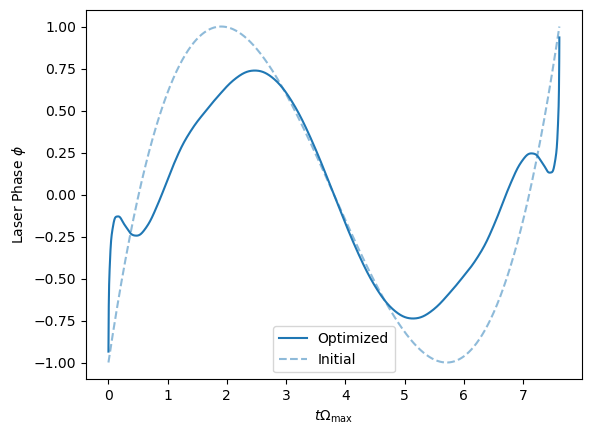

In [45]:
# plot piecewise-continouous gate
# plt.step(np.linspace(0, t_max, n_pieces), res.x[:-1], color="tab:blue", label="Optimized")
# plt.step(np.linspace(0, t_max, n_pieces), alpha0[:-1], alpha=0.35, label="Initial")
# plt.xlabel("$t\\Omega_{\\text{max}}$")
# plt.ylabel("Laser Phase $\\phi$")
# plt.legend()

# plot chebyshev gate
ts = np.linspace(0, t_max, 10001)
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("Laser Phase $\\phi$")
plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, res.x[:-1]), color="tab:blue", label="Optimized")
plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, alpha0), linestyle="--", alpha=0.5, label="Initial")
plt.legend()

plt.show()

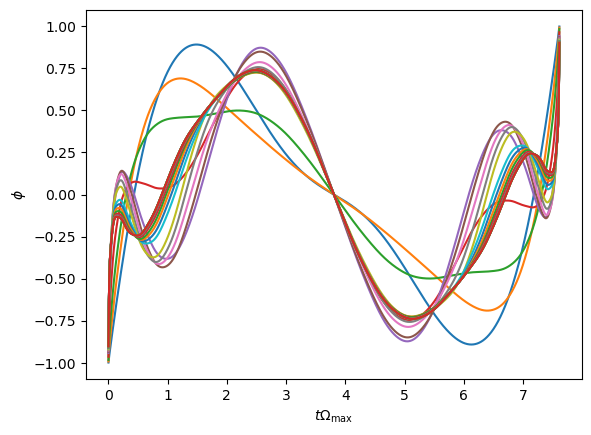

In [38]:
# plot how gate changed during optimization
for i in range(len(prev_params)):
    # plt.step(np.linspace(0, t_max, n_pieces), prev_params[i][:-1], alpha=0.3, label=f"{i}")

    ts = np.linspace(0, t_max, 10001)
    plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, prev_params[i][:-1]))
# plt.step(np.linspace(0, t_max, 100), prev_params[-2][:-1], alpha=0.3) # , label=f"{i}")
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("$\\phi$")
# plt.legend()
plt.show()

/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


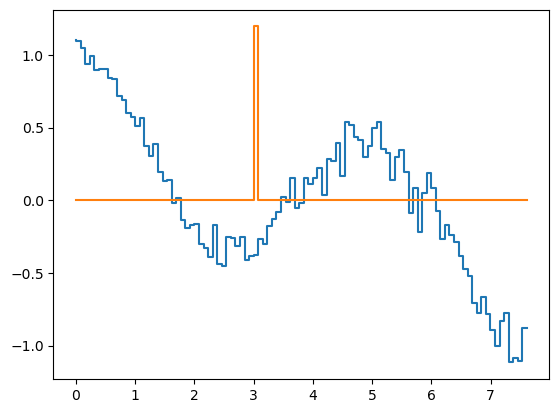

In [6]:
# check that piecewise controls are working
nts = 100
ts = np.linspace(0, t_max, nts)
controls = np.zeros(nts)
control_derivs = np.zeros(nts, dtype=complex)
deriv_j = 40
for i in range(nts):
    cval = to_control_func_plus(ts[i], res.x[:-1], control_extra_params)
    # print(cval)
    controls[i] = np.angle(cval)

    c_derivs = control_param_derivs(ts[i], res.x[:-1], control_extra_params)
    # print(c_derivs)
    control_derivs[i] = np.angle(c_derivs[0][deriv_j])

plt.step(ts, controls)
plt.step(ts, control_derivs)
plt.show()

F = 0.9995199192215024


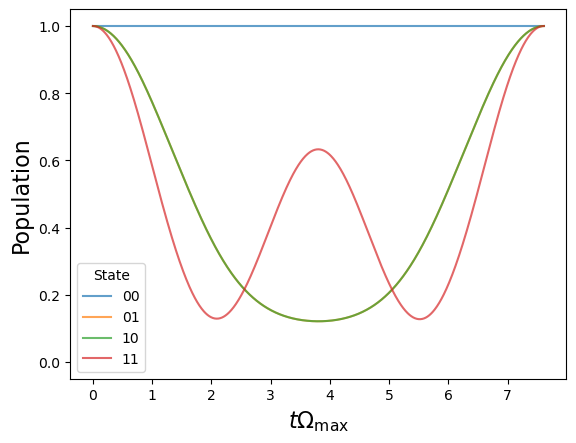

In [46]:
# simulate resulting gate in qutip
to_drive_strength_func = lambda t: 1
to_phase_func = lambda t: data_from_tstep(t, t_steps, res.x[:-1])

chebyshev_drive_strength_func = lambda t: 1
chebyshev_phase_func = lambda t: chebyshev.chebval((2/t_max)*t-1, res.x[:-1])

results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, 100, 0, t_min, t_max, 1001)
# results = simulate_gate(to_drive_strength_func, to_phase_func, 100, 0, t_min, t_max, 1001)
print(f"F = {calculate_fidelity(results, single_qubit_phase=res.x[-1])}")
plt.show()

-2.150085900238149
-2.1413095526868027
0.9998296602128983


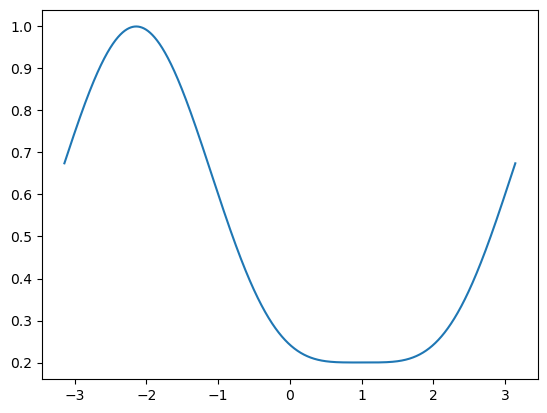

In [13]:
N = 10001
phases = np.linspace(-np.pi, np.pi, N)
fidelities = np.zeros(N)

for i in range(N):
    fidelities[i] = calculate_fidelity(results, single_qubit_phase=phases[i])
print(res.x[-1])
print(phases[np.argmax(fidelities)])
print(np.max(fidelities))

plt.plot(phases, fidelities)
plt.show()

## Sweep Gate Time

In [64]:
n_times = 14*5+1
gate_times = np.linspace(1, 15, n_times)
goat_results = []
fidelities = np.zeros(n_times)

control_funcs = [chebyshev_control_func_plus, chebyshev_control_func_minus]
control_param_derivs = chebyshev_control_param_derivs

n_cheb_polys = 10
alpha0 = np.zeros(n_cheb_polys + 1)
alpha0[3] = 1

for i in range(n_times):
    print(f"Gate time: {gate_times[i]}")
    t_min = 0
    t_max = gate_times[i] # from TO gates paper 
    t_span = [t_min, t_max]

    control_extra_params = {
        "Omega_max": 1,
        "t_max": gate_times[i],
        # "n_pieces": n_pieces
    }

    res = run_goat_optimization(
        H0,
        H_controls,
        control_funcs,
        control_param_derivs,
        alpha0,
        U_target,
        t_span,
        U_truncator,
        fidelity_func_name="GOAT",
        # alpha_bounds=alpha_bounds,
        constraints=chebyshev_constraint,
        single_qubit_phase_weights=[1, 2],
        control_extra_params=control_extra_params,
        callback=callback
    )

    goat_results.append(res)
    fidelities[i] = res.fun

Gate time: 1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61360D-01    |proj g|=  2.15888D-01


/Users/pranav/Documents/School/Princeton/Thesis/noise-robust-gates/goat_optimization.py:199: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  res = minimize(
 This problem is unconstrained.



At iterate    1    f=  1.64471D-01    |proj g|=  6.54481D-02

At iterate    2    f=  5.99851D-02    |proj g|=  1.48567D-01

At iterate    3    f=  1.17504D-02    |proj g|=  2.08281D-02

At iterate    4    f=  6.25420D-04    |proj g|=  7.42742D-03

At iterate    5    f=  3.83570D-06    |proj g|=  6.17964D-04

At iterate    6    f=  2.62353D-07    |proj g|=  6.54090D-05

At iterate    7    f=  2.18117D-07    |proj g|=  1.20096D-06

At iterate    8    f=  2.18108D-07    |proj g|=  2.44389D-07

At iterate    9    f=  2.18103D-07    |proj g|=  3.66480D-07

At iterate   10    f=  2.18033D-07    |proj g|=  1.65034D-06

At iterate   11    f=  2.17887D-07    |proj g|=  3.36237D-06

At iterate   12    f=  2.17444D-07    |proj g|=  6.44936D-06

At iterate   13    f=  2.15951D-07    |proj g|=  1.13237D-05

At iterate   14    f=  2.03685D-07    |proj g|=  2.95092D-05

At iterate   15    f=  2.03048D-07    |proj g|=  3.12888D-05

At iterate   16    f=  2.01416D-07    |proj g|=  1.94052D-05

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    1    f=  2.43793D-01    |proj g|=  5.09338D-02

At iterate    2    f=  5.20109D-02    |proj g|=  1.53852D-01

At iterate    3    f=  1.18053D-02    |proj g|=  7.18242D-02

At iterate    4    f=  1.53560D-03    |proj g|=  7.26680D-03

At iterate    5    f=  4.98934D-04    |proj g|=  3.32126D-03

At iterate    6    f=  1.66640D-04    |proj g|=  1.69415D-03

At iterate    7    f=  2.39830D-05    |proj g|=  1.02640D-03

At iterate    8    f=  6.18612D-07    |proj g|=  2.80666D-04

At iterate    9    f=  3.19186D-08    |proj g|=  3.85948D-05

At iterate   10    f=  2.21181D-08    |proj g|=  2.58003D-07

At iterate   11    f=  2.21148D-08    |proj g|=  8.11072D-08

At iterate   12    f=  2.21097D-08    |proj g|=  2.50107D-07

At iterate   13    f=  2.20922D-08    |proj g|=  4.29350D-07

At iterate   14    f=  2.20169D-08    |proj g|=  9.72846D-07

At iterate   15    f=  2.18171D-08    |proj g|=  1.69509D-06

At iterate   16    f=  1.85243D-08    |proj g|=  9.22847D-06

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  100    f=  6.57581D-10    |proj g|=  5.55336D-08

At iterate  101    f=  6.57566D-10    |proj g|=  1.81046D-08

At iterate  102    f=  6.57562D-10    |proj g|=  2.19940D-08

At iterate  103    f=  6.57550D-10    |proj g|=  1.87764D-08

At iterate  104    f=  6.57548D-10    |proj g|=  5.02088D-09
Gate time: 1.4

At iterate  105    f=  6.57548D-10    |proj g|=  9.27276D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11    105    161      2     0     0   9.273D-10   6.575D-10
  F =   6.5754823808106266E-010

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

         

 This problem is unconstrained.



At iterate    2    f=  9.77896D-02    |proj g|=  1.41874D-01

At iterate    3    f=  1.68615D-02    |proj g|=  8.84340D-02

At iterate    4    f=  3.12610D-03    |proj g|=  3.87643D-02

At iterate    5    f=  6.89598D-07    |proj g|=  1.99516D-04

At iterate    6    f=  1.76285D-07    |proj g|=  1.88723D-05

At iterate    7    f=  1.72088D-07    |proj g|=  3.52527D-07

At iterate    8    f=  1.72087D-07    |proj g|=  3.39688D-07

At iterate    9    f=  1.72079D-07    |proj g|=  1.08743D-06

At iterate   10    f=  1.72063D-07    |proj g|=  2.38783D-06

At iterate   11    f=  1.72016D-07    |proj g|=  4.75644D-06

At iterate   12    f=  1.71900D-07    |proj g|=  8.41036D-06

At iterate   13    f=  1.71592D-07    |proj g|=  1.43565D-05

At iterate   14    f=  1.70821D-07    |proj g|=  2.35659D-05

At iterate   15    f=  1.69094D-07    |proj g|=  3.64947D-05

At iterate   16    f=  1.66582D-07    |proj g|=  4.61218D-05

At iterate   17    f=  1.61931D-07    |proj g|=  4.02757D-05

At iter

 This problem is unconstrained.



At iterate    2    f=  9.11086D-05    |proj g|=  6.71879D-03

At iterate    3    f=  6.41154D-06    |proj g|=  1.08408D-03

At iterate    4    f=  1.56615D-06    |proj g|=  3.94464D-04

At iterate    5    f=  8.27020D-07    |proj g|=  1.48121D-06

At iterate    6    f=  8.26999D-07    |proj g|=  1.40748D-06

At iterate    7    f=  8.26937D-07    |proj g|=  1.85208D-06

At iterate    8    f=  8.26783D-07    |proj g|=  3.99718D-06

At iterate    9    f=  8.26369D-07    |proj g|=  7.55373D-06

At iterate   10    f=  8.25290D-07    |proj g|=  1.38614D-05

At iterate   11    f=  8.22389D-07    |proj g|=  2.43950D-05

At iterate   12    f=  8.13965D-07    |proj g|=  4.16994D-05

At iterate   13    f=  6.36535D-07    |proj g|=  1.29045D-04

At iterate   14    f=  6.26491D-07    |proj g|=  1.06049D-04

At iterate   15    f=  5.74402D-07    |proj g|=  4.63719D-05

At iterate   16    f=  5.68326D-07    |proj g|=  5.09170D-05

At iterate   17    f=  5.33620D-07    |proj g|=  1.13054D-04

At iter

 This problem is unconstrained.



At iterate    2    f=  4.38240D-01    |proj g|=  2.40877D-01

At iterate    3    f=  2.01367D-01    |proj g|=  2.79815D-01

At iterate    4    f=  6.52828D-02    |proj g|=  8.36074D-02

At iterate    5    f=  8.16483D-03    |proj g|=  4.20101D-02

At iterate    6    f=  8.91216D-04    |proj g|=  2.05612D-02

At iterate    7    f=  1.66559D-04    |proj g|=  8.34727D-03

At iterate    8    f=  1.14174D-06    |proj g|=  1.85163D-04

At iterate    9    f=  1.05144D-06    |proj g|=  3.06881D-05

At iterate   10    f=  1.04868D-06    |proj g|=  9.52776D-07

At iterate   11    f=  1.04840D-06    |proj g|=  3.40591D-06

At iterate   12    f=  1.04634D-06    |proj g|=  1.69370D-05

At iterate   13    f=  1.04142D-06    |proj g|=  3.77932D-05

At iterate   14    f=  1.03046D-06    |proj g|=  6.75219D-05

At iterate   15    f=  1.01146D-06    |proj g|=  9.79373D-05

At iterate   16    f=  9.80694D-07    |proj g|=  1.12073D-04

At iterate   17    f=  9.22407D-07    |proj g|=  9.07993D-05

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    2    f=  4.81161D-01    |proj g|=  3.08099D-01

At iterate    3    f=  3.00523D-01    |proj g|=  2.51197D-01

At iterate    4    f=  1.88332D-01    |proj g|=  1.54993D-01

At iterate    5    f=  1.20207D-03    |proj g|=  2.07663D-02

At iterate    6    f=  9.86587D-04    |proj g|=  1.93148D-02

At iterate    7    f=  3.49231D-04    |proj g|=  1.02306D-02

At iterate    8    f=  9.76067D-05    |proj g|=  6.50709D-03

At iterate    9    f=  1.29465D-05    |proj g|=  7.45263D-04

At iterate   10    f=  1.13997D-05    |proj g|=  1.03761D-04

At iterate   11    f=  1.13744D-05    |proj g|=  1.95373D-05

At iterate   12    f=  1.13534D-05    |proj g|=  4.12978D-05

At iterate   13    f=  1.12638D-05    |proj g|=  9.37503D-05

At iterate   14    f=  1.09255D-05    |proj g|=  2.47303D-04

At iterate   15    f=  1.01138D-05    |proj g|=  4.92194D-04

At iterate   16    f=  8.08529D-06    |proj g|=  1.05518D-03

At iterate   17    f=  5.77769D-06    |proj g|=  1.20910D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   89    f=  1.05029D-09    |proj g|=  6.31249D-07

At iterate   90    f=  1.04934D-09    |proj g|=  2.53262D-09
Gate time: 2.2
At iterate   91    f=  1.04934D-09    |proj g|=  2.13595D-09


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     91    144      2     0     0   2.136D-09   1.049D-09
  F =   1.0493419466683918E-009

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52588D-01    |proj g|=  2.352

 This problem is unconstrained.



At iterate    2    f=  1.03508D-01    |proj g|=  1.58125D-01

At iterate    3    f=  5.27433D-03    |proj g|=  3.24203D-02

At iterate    4    f=  1.95235D-04    |proj g|=  5.30567D-03

At iterate    5    f=  1.30476D-04    |proj g|=  2.05108D-03

At iterate    6    f=  1.17237D-04    |proj g|=  2.47471D-04

At iterate    7    f=  1.15507D-04    |proj g|=  3.16741D-04

At iterate    8    f=  1.06284D-04    |proj g|=  1.06175D-03

At iterate    9    f=  9.73219D-05    |proj g|=  1.30427D-03

At iterate   10    f=  7.95081D-05    |proj g|=  1.29389D-03

At iterate   11    f=  5.23599D-05    |proj g|=  4.13145D-04

At iterate   12    f=  4.23609D-05    |proj g|=  9.39450D-04

At iterate   13    f=  2.65218D-05    |proj g|=  1.28246D-03

At iterate   14    f=  2.07269D-05    |proj g|=  1.04148D-03

At iterate   15    f=  1.67139D-05    |proj g|=  1.05523D-03

At iterate   16    f=  1.03118D-05    |proj g|=  3.86517D-04

At iterate   17    f=  8.30696D-06    |proj g|=  3.41227D-04

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    2    f=  8.33635D-02    |proj g|=  1.68708D-01

At iterate    3    f=  2.30248D-02    |proj g|=  1.01564D-01

At iterate    4    f=  7.32562D-04    |proj g|=  5.42380D-03

At iterate    5    f=  6.28194D-04    |proj g|=  1.39072D-03

At iterate    6    f=  6.18200D-04    |proj g|=  1.25571D-03

At iterate    7    f=  5.07069D-04    |proj g|=  3.82291D-03

At iterate    8    f=  2.66935D-04    |proj g|=  5.97729D-03

At iterate    9    f=  1.24531D-04    |proj g|=  2.80330D-03

At iterate   10    f=  8.48515D-05    |proj g|=  4.89793D-04

At iterate   11    f=  6.26950D-05    |proj g|=  2.65729D-03

At iterate   12    f=  5.04211D-05    |proj g|=  2.07400D-03

At iterate   13    f=  1.47725D-05    |proj g|=  1.47133D-04

At iterate   14    f=  5.61775D-06    |proj g|=  3.75247D-04

At iterate   15    f=  3.89043D-06    |proj g|=  1.05795D-03

At iterate   16    f=  5.95516D-07    |proj g|=  7.79382D-05

At iterate   17    f=  1.48142D-07    |proj g|=  7.19837D-05

At iter

 This problem is unconstrained.



At iterate    2    f=  2.37805D-01    |proj g|=  3.11318D-01

At iterate    3    f=  1.21101D-01    |proj g|=  2.73446D-01

At iterate    4    f=  7.96541D-03    |proj g|=  9.59910D-02

At iterate    5    f=  1.27454D-03    |proj g|=  2.16352D-02

At iterate    6    f=  4.05876D-04    |proj g|=  1.25485D-02

At iterate    7    f=  2.09635D-05    |proj g|=  3.31431D-04

At iterate    8    f=  2.06902D-05    |proj g|=  8.76851D-05

At iterate    9    f=  2.00444D-05    |proj g|=  2.07964D-04

At iterate   10    f=  1.75085D-05    |proj g|=  6.26978D-04

At iterate   11    f=  1.31488D-05    |proj g|=  2.71701D-03

At iterate   12    f=  8.39081D-06    |proj g|=  8.63747D-04

At iterate   13    f=  3.31650D-06    |proj g|=  4.37931D-04

At iterate   14    f=  1.21141D-06    |proj g|=  8.57154D-04

At iterate   15    f=  4.16809D-07    |proj g|=  2.25781D-04

At iterate   16    f=  2.09027D-07    |proj g|=  2.18621D-04

At iterate   17    f=  2.02295D-08    |proj g|=  7.09022D-05

At iter

 This problem is unconstrained.



At iterate    2    f=  3.22505D-01    |proj g|=  3.57369D-01

At iterate    3    f=  1.31188D-01    |proj g|=  3.92072D-01

At iterate    4    f=  9.13059D-02    |proj g|=  2.07066D-01

At iterate    5    f=  1.51014D-02    |proj g|=  5.99236D-02

At iterate    6    f=  4.47213D-03    |proj g|=  7.59831D-03

At iterate    7    f=  3.42038D-03    |proj g|=  1.99662D-02

At iterate    8    f=  2.65763D-03    |proj g|=  2.26514D-02

At iterate    9    f=  1.35482D-03    |proj g|=  1.58646D-02

At iterate   10    f=  9.51183D-05    |proj g|=  6.43013D-03

At iterate   11    f=  6.03454D-06    |proj g|=  1.37373D-03

At iterate   12    f=  1.38788D-06    |proj g|=  2.35788D-06

At iterate   13    f=  1.38771D-06    |proj g|=  4.85144D-07

At iterate   14    f=  1.38131D-06    |proj g|=  4.57620D-06

At iterate   15    f=  1.31186D-06    |proj g|=  9.26455D-06

At iterate   16    f=  1.30791D-06    |proj g|=  1.54047D-05

At iterate   17    f=  1.29855D-06    |proj g|=  1.58156D-05

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  106    f=  3.45913D-09    |proj g|=  5.70696D-08

At iterate  107    f=  3.45911D-09    |proj g|=  1.44054D-08

At iterate  108    f=  3.45911D-09    |proj g|=  9.68835D-09

At iterate  109    f=  3.45911D-09    |proj g|=  2.67109D-09
Gate time: 3.0
At iterate  110    f=  3.45911D-09    |proj g|=  9.10517D-10


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11    110    186      2     0     0   9.105D-10   3.459D-09
  F =   3.4591086661706072E-009

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M

 This problem is unconstrained.



At iterate    2    f=  3.19251D-01    |proj g|=  3.54054D-01

At iterate    3    f=  1.60438D-01    |proj g|=  4.64179D-01

At iterate    4    f=  2.05836D-02    |proj g|=  8.20912D-02

At iterate    5    f=  1.35275D-02    |proj g|=  2.06429D-02

At iterate    6    f=  2.28093D-03    |proj g|=  2.43366D-02

At iterate    7    f=  6.29882D-04    |proj g|=  1.77002D-02

At iterate    8    f=  7.75739D-06    |proj g|=  1.44107D-03

At iterate    9    f=  2.46573D-06    |proj g|=  1.07059D-04

At iterate   10    f=  2.39001D-06    |proj g|=  1.05507D-05

At iterate   11    f=  2.38886D-06    |proj g|=  5.18010D-06

At iterate   12    f=  2.38851D-06    |proj g|=  5.01082D-06

At iterate   13    f=  2.38412D-06    |proj g|=  1.77739D-05

At iterate   14    f=  2.37482D-06    |proj g|=  3.40033D-05

At iterate   15    f=  2.34740D-06    |proj g|=  6.48135D-05

At iterate   16    f=  2.27584D-06    |proj g|=  1.15117D-04

At iterate   17    f=  2.05938D-06    |proj g|=  2.08829D-04

At iter

 This problem is unconstrained.



At iterate    2    f=  2.47920D-01    |proj g|=  3.11472D-01

At iterate    3    f=  1.87653D-01    |proj g|=  5.41763D-01

At iterate    4    f=  4.94045D-02    |proj g|=  1.84661D-01

At iterate    5    f=  2.35192D-02    |proj g|=  9.76602D-02

At iterate    6    f=  6.12886D-03    |proj g|=  4.95773D-02

At iterate    7    f=  1.99656D-04    |proj g|=  9.93047D-03

At iterate    8    f=  1.34731D-04    |proj g|=  1.45099D-03

At iterate    9    f=  1.33572D-04    |proj g|=  4.57106D-04

At iterate   10    f=  1.33087D-04    |proj g|=  4.31435D-04

At iterate   11    f=  1.29436D-04    |proj g|=  1.44176D-03

At iterate   12    f=  1.23209D-04    |proj g|=  3.10333D-03

At iterate   13    f=  1.12181D-04    |proj g|=  5.42446D-03

At iterate   14    f=  9.68752D-05    |proj g|=  6.19309D-03

At iterate   15    f=  5.64427D-05    |proj g|=  5.42298D-03

At iterate   16    f=  2.51349D-05    |proj g|=  1.65943D-03

At iterate   17    f=  1.10898D-05    |proj g|=  1.37875D-03

At iter

 This problem is unconstrained.



At iterate    2    f=  1.42799D-01    |proj g|=  2.20039D-01

At iterate    3    f=  1.08462D-01    |proj g|=  2.22483D-01

At iterate    4    f=  1.13819D-02    |proj g|=  6.61095D-02

At iterate    5    f=  5.49291D-03    |proj g|=  4.21578D-02

At iterate    6    f=  7.08956D-05    |proj g|=  3.95624D-03

At iterate    7    f=  1.64214D-06    |proj g|=  3.08442D-04

At iterate    8    f=  1.33806D-08    |proj g|=  1.42499D-05

At iterate    9    f=  1.29934D-08    |proj g|=  3.34433D-06

At iterate   10    f=  1.29701D-08    |proj g|=  6.22628D-09

At iterate   11    f=  1.29701D-08    |proj g|=  6.75244D-09

At iterate   12    f=  1.29701D-08    |proj g|=  6.95847D-09

At iterate   13    f=  1.29700D-08    |proj g|=  2.69464D-08

At iterate   14    f=  1.29700D-08    |proj g|=  1.16178D-07

At iterate   15    f=  1.29700D-08    |proj g|=  1.17912D-07

At iterate   16    f=  1.29699D-08    |proj g|=  1.39493D-07
Gate time: 3.6
At iterate   17    f=  1.29699D-08    |proj g|=  1.3955

 This problem is unconstrained.



At iterate    2    f=  8.51013D-02    |proj g|=  1.67637D-01

At iterate    3    f=  1.45618D-02    |proj g|=  5.52164D-02

At iterate    4    f=  9.79088D-03    |proj g|=  3.26476D-02

At iterate    5    f=  8.33522D-03    |proj g|=  2.00666D-02

At iterate    6    f=  6.70965D-03    |proj g|=  1.48831D-02

At iterate    7    f=  5.03206D-03    |proj g|=  3.60697D-02

At iterate    8    f=  3.17990D-03    |proj g|=  2.21505D-02

At iterate    9    f=  6.66055D-04    |proj g|=  6.56861D-03

At iterate   10    f=  2.86926D-04    |proj g|=  3.34511D-03

At iterate   11    f=  7.08451D-05    |proj g|=  1.03768D-03

At iterate   12    f=  1.95604D-05    |proj g|=  9.45213D-04

At iterate   13    f=  1.23501D-05    |proj g|=  2.72603D-03

At iterate   14    f=  1.72446D-06    |proj g|=  4.81340D-04

At iterate   15    f=  2.64817D-07    |proj g|=  1.28989D-04

At iterate   16    f=  1.14439D-08    |proj g|=  3.19849D-05

At iterate   17    f=  1.70504D-09    |proj g|=  2.62233D-05

At iter

 This problem is unconstrained.



At iterate    2    f=  2.47269D-01    |proj g|=  3.56603D-01

At iterate    3    f=  1.43092D-01    |proj g|=  2.14854D-01

At iterate    4    f=  2.15632D-02    |proj g|=  7.30862D-02

At iterate    5    f=  7.16205D-03    |proj g|=  1.61993D-02

At iterate    6    f=  4.87247D-03    |proj g|=  1.24603D-02

At iterate    7    f=  2.07142D-03    |proj g|=  8.83816D-03

At iterate    8    f=  1.15606D-03    |proj g|=  8.46700D-03

At iterate    9    f=  5.78607D-04    |proj g|=  1.18720D-02

At iterate   10    f=  1.63105D-04    |proj g|=  4.79109D-03

At iterate   11    f=  1.02977D-04    |proj g|=  4.42018D-03

At iterate   12    f=  4.29970D-05    |proj g|=  8.99885D-04

At iterate   13    f=  2.07752D-05    |proj g|=  1.97382D-03

At iterate   14    f=  9.50925D-06    |proj g|=  5.86039D-04

At iterate   15    f=  6.37787D-06    |proj g|=  2.87319D-04

At iterate   16    f=  4.34801D-06    |proj g|=  1.25088D-04

At iterate   17    f=  3.86804D-06    |proj g|=  2.96633D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   76    f=  2.00213D-09    |proj g|=  3.34587D-08
Gate time: 4.0

At iterate   77    f=  2.00213D-09    |proj g|=  1.22643D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     77    119      2     0     0   1.226D-08   2.002D-09
  F =   2.0021326818664420E-009

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86781D-01    |proj g|=  2.22181D-01


 This problem is unconstrained.



At iterate    1    f=  6.59002D-01    |proj g|=  1.75439D-01

At iterate    2    f=  6.02075D-01    |proj g|=  4.26442D-01

At iterate    3    f=  7.22412D-02    |proj g|=  1.28007D-01

At iterate    4    f=  4.35853D-02    |proj g|=  1.06980D-01

At iterate    5    f=  2.92621D-02    |proj g|=  9.66095D-02

At iterate    6    f=  7.34668D-03    |proj g|=  4.01129D-02

At iterate    7    f=  2.92805D-04    |proj g|=  8.79303D-03

At iterate    8    f=  3.04175D-05    |proj g|=  2.47004D-03

At iterate    9    f=  6.49793D-06    |proj g|=  1.31758D-03

At iterate   10    f=  1.99383D-06    |proj g|=  1.44645D-04

At iterate   11    f=  1.93744D-06    |proj g|=  2.91314D-05

At iterate   12    f=  1.92745D-06    |proj g|=  2.50754D-05

At iterate   13    f=  1.87811D-06    |proj g|=  7.94688D-05

At iterate   14    f=  1.78024D-06    |proj g|=  1.56152D-04

At iterate   15    f=  1.56399D-06    |proj g|=  2.60277D-04

At iterate   16    f=  1.26747D-06    |proj g|=  3.11325D-04

At iter

 This problem is unconstrained.



At iterate    3    f=  1.21202D-01    |proj g|=  4.12853D-01

At iterate    4    f=  5.97812D-03    |proj g|=  1.14489D-01

At iterate    5    f=  3.47154D-03    |proj g|=  7.08005D-02

At iterate    6    f=  1.64433D-03    |proj g|=  5.62729D-02

At iterate    7    f=  3.82406D-04    |proj g|=  7.25684D-04

At iterate    8    f=  3.53116D-04    |proj g|=  1.31790D-03

At iterate    9    f=  2.72466D-04    |proj g|=  1.17925D-02

At iterate   10    f=  2.20788D-04    |proj g|=  4.12841D-03

At iterate   11    f=  1.62372D-04    |proj g|=  2.13835D-03

At iterate   12    f=  1.45198D-04    |proj g|=  5.17225D-03

At iterate   13    f=  1.31795D-04    |proj g|=  7.12262D-04

At iterate   14    f=  1.25464D-04    |proj g|=  1.36117D-03

At iterate   15    f=  1.22915D-04    |proj g|=  5.93449D-04

At iterate   16    f=  1.22033D-04    |proj g|=  2.86927D-04

At iterate   17    f=  1.21469D-04    |proj g|=  2.51416D-04

At iterate   18    f=  1.21028D-04    |proj g|=  1.21585D-04

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    2    f=  4.23054D-01    |proj g|=  4.01252D-01

At iterate    3    f=  3.46928D-01    |proj g|=  5.11103D-01

At iterate    4    f=  2.28011D-01    |proj g|=  2.04615D-01

At iterate    5    f=  1.58935D-01    |proj g|=  1.44599D-01

At iterate    6    f=  8.41251D-02    |proj g|=  1.17485D-01

At iterate    7    f=  4.84605D-02    |proj g|=  5.11126D-02

At iterate    8    f=  3.48683D-02    |proj g|=  8.16248D-02

At iterate    9    f=  1.61938D-02    |proj g|=  7.21405D-02

At iterate   10    f=  7.54785D-03    |proj g|=  4.59178D-02

At iterate   11    f=  8.29235D-04    |proj g|=  1.16145D-02

At iterate   12    f=  4.28162D-04    |proj g|=  1.72790D-02

At iterate   13    f=  7.15636D-05    |proj g|=  3.46537D-03

At iterate   14    f=  1.60906D-05    |proj g|=  1.20724D-03

At iterate   15    f=  3.43622D-07    |proj g|=  2.78766D-04

At iterate   16    f=  1.75854D-07    |proj g|=  4.04247D-04

At iterate   17    f=  6.98707D-09    |proj g|=  8.13573D-05

At iter

 This problem is unconstrained.



At iterate    2    f=  6.34111D-01    |proj g|=  6.01772D-01

At iterate    3    f=  4.58802D-02    |proj g|=  1.39804D-01

At iterate    4    f=  5.54329D-03    |proj g|=  1.38265D-02

At iterate    5    f=  5.37967D-03    |proj g|=  9.74257D-03

At iterate    6    f=  4.43661D-03    |proj g|=  1.30529D-02

At iterate    7    f=  3.10764D-03    |proj g|=  2.07156D-02

At iterate    8    f=  2.30494D-03    |proj g|=  2.45021D-02

At iterate    9    f=  1.33764D-03    |proj g|=  1.67416D-02

At iterate   10    f=  5.78107D-04    |proj g|=  3.93923D-03

At iterate   11    f=  3.35734D-04    |proj g|=  8.09237D-03

At iterate   12    f=  1.39010D-04    |proj g|=  8.12511D-03

At iterate   13    f=  1.01576D-04    |proj g|=  8.42013D-03

At iterate   14    f=  2.30098D-05    |proj g|=  7.61805D-04

At iterate   15    f=  8.84730D-06    |proj g|=  4.00452D-03

At iterate   16    f=  5.11002D-07    |proj g|=  2.28362D-04

At iterate   17    f=  3.05871D-08    |proj g|=  5.55320D-05

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   21    f=  1.42235D-09    |proj g|=  1.51561D-08
Gate time: 4.800000000000001

At iterate   22    f=  1.42235D-09    |proj g|=  7.89252D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     22     51      2     0     0   7.893D-09   1.422D-09
  F =   1.4223507927013657E-009

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37743D-01    |proj g|=  1.43072D-01


 This problem is unconstrained.



At iterate    1    f=  7.97441D-01    |proj g|=  2.03272D-01

At iterate    2    f=  7.50117D-01    |proj g|=  6.12209D-02

At iterate    3    f=  6.55186D-01    |proj g|=  2.40204D-01

At iterate    4    f=  6.86887D-03    |proj g|=  3.47930D-02

At iterate    5    f=  6.00448D-03    |proj g|=  4.67991D-02

At iterate    6    f=  7.79879D-04    |proj g|=  7.18540D-03

At iterate    7    f=  2.52714D-04    |proj g|=  4.10746D-03

At iterate    8    f=  4.27906D-06    |proj g|=  1.07112D-03

At iterate    9    f=  3.13810D-07    |proj g|=  1.36498D-04

At iterate   10    f=  2.69823D-07    |proj g|=  7.95551D-06

At iterate   11    f=  2.69580D-07    |proj g|=  4.27429D-07

At iterate   12    f=  2.69562D-07    |proj g|=  5.90829D-07

At iterate   13    f=  2.69355D-07    |proj g|=  2.20346D-06

At iterate   14    f=  2.68862D-07    |proj g|=  4.69380D-06

At iterate   15    f=  2.67286D-07    |proj g|=  9.03820D-06

At iterate   16    f=  2.49017D-07    |proj g|=  8.77016D-06

At iter

 This problem is unconstrained.



At iterate    2    f=  5.02616D-01    |proj g|=  4.29171D-01

At iterate    3    f=  1.07025D-01    |proj g|=  2.63489D-01

At iterate    4    f=  3.33488D-02    |proj g|=  1.21819D-01

At iterate    5    f=  1.40387D-02    |proj g|=  1.05974D-01

At iterate    6    f=  2.12343D-03    |proj g|=  1.99846D-02

At iterate    7    f=  1.43103D-03    |proj g|=  5.78724D-03

At iterate    8    f=  1.32776D-03    |proj g|=  3.87301D-03

At iterate    9    f=  1.29077D-03    |proj g|=  3.69625D-03

At iterate   10    f=  1.16760D-03    |proj g|=  7.69009D-03

At iterate   11    f=  4.12730D-04    |proj g|=  2.46713D-03

At iterate   12    f=  3.75710D-04    |proj g|=  6.89773D-03

At iterate   13    f=  2.95749D-04    |proj g|=  7.39285D-03

At iterate   14    f=  4.30405D-05    |proj g|=  7.14653D-03

At iterate   15    f=  3.68675D-06    |proj g|=  3.54364D-04

At iterate   16    f=  8.56308D-07    |proj g|=  5.39157D-04

At iterate   17    f=  9.65527D-09    |proj g|=  5.44482D-05

At iter

 This problem is unconstrained.



At iterate    1    f=  2.26793D-01    |proj g|=  4.45478D-01

At iterate    2    f=  1.65141D-01    |proj g|=  7.25050D-01

At iterate    3    f=  5.23847D-03    |proj g|=  4.10964D-02

At iterate    4    f=  2.98456D-03    |proj g|=  2.88148D-02

At iterate    5    f=  1.99776D-03    |proj g|=  9.25736D-03

At iterate    6    f=  1.18393D-03    |proj g|=  1.55085D-02

At iterate    7    f=  4.68997D-04    |proj g|=  5.05118D-03

At iterate    8    f=  1.41714D-04    |proj g|=  1.47106D-02

At iterate    9    f=  3.94267D-05    |proj g|=  7.18037D-03

At iterate   10    f=  6.10528D-06    |proj g|=  1.07431D-03

At iterate   11    f=  8.51592D-07    |proj g|=  9.28326D-04

At iterate   12    f=  3.48406D-08    |proj g|=  2.62763D-04

At iterate   13    f=  4.13500D-09    |proj g|=  6.68581D-05

At iterate   14    f=  2.38785D-09    |proj g|=  8.35343D-07

At iterate   15    f=  2.38384D-09    |proj g|=  5.40209D-08

At iterate   16    f=  2.38381D-09    |proj g|=  5.66737D-08

At iter

 This problem is unconstrained.



At iterate    1    f=  2.01358D-01    |proj g|=  2.66096D-01

At iterate    2    f=  1.93198D-01    |proj g|=  2.96058D-01

At iterate    3    f=  1.29406D-01    |proj g|=  2.21351D-01

At iterate    4    f=  3.05501D-02    |proj g|=  2.25451D-01

At iterate    5    f=  6.77188D-03    |proj g|=  4.80065D-02

At iterate    6    f=  3.02621D-04    |proj g|=  1.43834D-02

At iterate    7    f=  7.21608D-06    |proj g|=  9.28888D-04

At iterate    8    f=  5.41827D-06    |proj g|=  5.77479D-04

At iterate    9    f=  1.30915D-06    |proj g|=  4.47359D-04

At iterate   10    f=  1.39621D-07    |proj g|=  2.45187D-04

At iterate   11    f=  1.21992D-07    |proj g|=  2.28175D-04

At iterate   12    f=  5.89675D-09    |proj g|=  3.67524D-05

At iterate   13    f=  3.60878D-09    |proj g|=  4.69075D-06

At iterate   14    f=  3.53332D-09    |proj g|=  1.52781D-07

At iterate   15    f=  3.53312D-09    |proj g|=  1.05219D-08

At iterate   16    f=  3.53312D-09    |proj g|=  4.22234D-09



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Gate time: 5.6000000000000005
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

   11     17     59      2     0     0   4.222D-09   3.533D-09
  F =   3.5331154668583054E-009

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48884D-01    |proj g|=  3.10683D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    1    f=  4.38816D-01    |proj g|=  3.70226D-01

At iterate    2    f=  2.44754D-01    |proj g|=  3.72137D-01

At iterate    3    f=  5.21560D-02    |proj g|=  1.22715D-01

At iterate    4    f=  2.53684D-02    |proj g|=  1.40112D-01

At iterate    5    f=  4.00974D-03    |proj g|=  2.26996D-02

At iterate    6    f=  1.47989D-03    |proj g|=  1.22231D-02

At iterate    7    f=  7.89420D-04    |proj g|=  1.41009D-02

At iterate    8    f=  2.74775D-04    |proj g|=  5.77378D-03

At iterate    9    f=  4.91650D-05    |proj g|=  1.59653D-03

At iterate   10    f=  9.61310D-06    |proj g|=  6.89022D-04

At iterate   11    f=  8.20998D-06    |proj g|=  1.64459D-03

At iterate   12    f=  6.54542D-07    |proj g|=  2.53672D-04

At iterate   13    f=  2.40873D-08    |proj g|=  3.25844D-05

At iterate   14    f=  5.83088D-09    |proj g|=  1.66391D-05

At iterate   15    f=  5.01524D-09    |proj g|=  2.96409D-06

At iterate   16    f=  4.98400D-09    |proj g|=  4.46494D-07

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    2    f=  9.14592D-02    |proj g|=  1.48437D-01

At iterate    3    f=  8.41438D-02    |proj g|=  1.50783D-02

At iterate    4    f=  8.34436D-02    |proj g|=  8.31662D-03

At iterate    5    f=  8.02968D-02    |proj g|=  3.12563D-02

At iterate    6    f=  4.76868D-02    |proj g|=  9.52219D-02

At iterate    7    f=  4.73264D-02    |proj g|=  1.05545D-01

At iterate    8    f=  3.80461D-02    |proj g|=  8.33908D-02

At iterate    9    f=  1.05776D-02    |proj g|=  5.57366D-02

At iterate   10    f=  3.77587D-03    |proj g|=  2.23420D-02

At iterate   11    f=  1.44741D-03    |proj g|=  1.23787D-02

At iterate   12    f=  6.09137D-04    |proj g|=  1.10732D-02

At iterate   13    f=  2.98291D-04    |proj g|=  3.28215D-03

At iterate   14    f=  1.31669D-04    |proj g|=  2.83935D-03

At iterate   15    f=  6.60200D-05    |proj g|=  1.40009D-03

At iterate   16    f=  3.96677D-05    |proj g|=  1.04103D-03

At iterate   17    f=  2.88070D-05    |proj g|=  2.10766D-03

At iter

 This problem is unconstrained.



At iterate    2    f=  1.69204D-01    |proj g|=  2.34021D-01

At iterate    3    f=  1.22398D-01    |proj g|=  1.08486D-01

At iterate    4    f=  9.14107D-02    |proj g|=  8.56843D-02

At iterate    5    f=  8.13514D-02    |proj g|=  5.21173D-02

At iterate    6    f=  7.55362D-02    |proj g|=  6.10185D-02

At iterate    7    f=  7.29329D-02    |proj g|=  5.80016D-02

At iterate    8    f=  7.14383D-02    |proj g|=  1.91327D-02

At iterate    9    f=  7.08228D-02    |proj g|=  6.35188D-03

At iterate   10    f=  7.06688D-02    |proj g|=  1.01053D-02

At iterate   11    f=  7.04609D-02    |proj g|=  1.02385D-02

At iterate   12    f=  2.88151D-03    |proj g|=  2.80626D-02

At iterate   13    f=  2.78349D-03    |proj g|=  2.99499D-02

At iterate   14    f=  9.02249D-05    |proj g|=  4.67829D-03

At iterate   15    f=  3.38502D-05    |proj g|=  2.45470D-03

At iterate   16    f=  2.07473D-05    |proj g|=  1.49599D-03

At iterate   17    f=  4.04421D-06    |proj g|=  5.91917D-04

At iter

 This problem is unconstrained.



At iterate    2    f=  1.60300D-01    |proj g|=  3.51578D-01

At iterate    3    f=  5.97538D-02    |proj g|=  6.38504D-02

At iterate    4    f=  5.77522D-02    |proj g|=  5.73067D-02

At iterate    5    f=  5.64142D-02    |proj g|=  2.12226D-02

At iterate    6    f=  5.61334D-02    |proj g|=  2.25026D-02

At iterate    7    f=  5.31641D-02    |proj g|=  6.45475D-02

At iterate    8    f=  2.82847D-02    |proj g|=  1.90768D-01

At iterate    9    f=  2.41020D-02    |proj g|=  1.05453D-01

At iterate   10    f=  1.42799D-02    |proj g|=  7.73476D-02

At iterate   11    f=  3.32709D-03    |proj g|=  8.80893D-02

At iterate   12    f=  1.91553D-03    |proj g|=  1.85424D-02

At iterate   13    f=  3.25837D-05    |proj g|=  5.70629D-03

At iterate   14    f=  1.76427D-07    |proj g|=  2.38111D-04

At iterate   15    f=  1.87892D-09    |proj g|=  1.90967D-05

At iterate   16    f=  1.63947D-09    |proj g|=  1.97958D-05

At iterate   17    f=  1.57393D-09    |proj g|=  7.97706D-06

At iter

 This problem is unconstrained.



At iterate    2    f=  2.59552D-01    |proj g|=  2.88302D-01

At iterate    3    f=  1.11914D-01    |proj g|=  5.70312D-01

At iterate    4    f=  5.34625D-02    |proj g|=  1.00720D-01

At iterate    5    f=  5.08789D-02    |proj g|=  5.41614D-02

At iterate    6    f=  4.92564D-02    |proj g|=  5.71315D-02

At iterate    7    f=  4.57379D-02    |proj g|=  8.12197D-02

At iterate    8    f=  4.31341D-02    |proj g|=  5.36665D-02

At iterate    9    f=  4.09505D-02    |proj g|=  2.59901D-02

At iterate   10    f=  3.94822D-02    |proj g|=  4.57720D-02

At iterate   11    f=  3.73926D-02    |proj g|=  1.00444D-01

At iterate   12    f=  3.41872D-02    |proj g|=  1.83996D-01

At iterate   13    f=  2.74408D-02    |proj g|=  1.78110D-01

At iterate   14    f=  3.33129D-04    |proj g|=  2.47338D-02

At iterate   15    f=  1.48875D-04    |proj g|=  7.84388D-03

At iterate   16    f=  2.29351D-05    |proj g|=  4.06840D-03

At iterate   17    f=  8.25385D-07    |proj g|=  1.00607D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Gate time: 6.6000000000000005
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     21     63      2     0     0   8.650D-09   1.845D-09
  F =   1.8450795336022452E-009

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.96269D-01    |proj g|=  4.53308D-01

At iterate    1    f=  5.35631D-01    |proj g|=  8.43309D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    2    f=  3.11883D-01    |proj g|=  2.83366D-01

At iterate    3    f=  1.77524D-01    |proj g|=  2.94262D-01

At iterate    4    f=  6.37190D-02    |proj g|=  1.66133D-01

At iterate    5    f=  3.47655D-02    |proj g|=  7.41034D-02

At iterate    6    f=  3.26045D-02    |proj g|=  3.93748D-02

At iterate    7    f=  3.14600D-02    |proj g|=  4.55232D-02

At iterate    8    f=  2.74985D-02    |proj g|=  5.72896D-02

At iterate    9    f=  1.92137D-02    |proj g|=  1.65075D-01

At iterate   10    f=  1.08200D-02    |proj g|=  1.94270D-01

At iterate   11    f=  3.50903D-03    |proj g|=  3.30401D-02

At iterate   12    f=  4.60637D-05    |proj g|=  1.63314D-02

At iterate   13    f=  1.61755D-06    |proj g|=  2.02336D-03

At iterate   14    f=  3.82729D-09    |proj g|=  2.17156D-05

At iterate   15    f=  1.17595D-09    |proj g|=  2.24147D-06

At iterate   16    f=  1.17445D-09    |proj g|=  1.86937D-06

At iterate   17    f=  1.17326D-09    |proj g|=  5.14118D-08
Gate tim

 This problem is unconstrained.



At iterate    1    f=  4.56467D-01    |proj g|=  3.21686D-01

At iterate    2    f=  3.30180D-01    |proj g|=  5.21298D-01

At iterate    3    f=  1.20416D-01    |proj g|=  1.89405D-01

At iterate    4    f=  5.18619D-02    |proj g|=  3.64098D-01

At iterate    5    f=  2.83767D-02    |proj g|=  7.62726D-02

At iterate    6    f=  2.67563D-02    |proj g|=  3.98236D-02

At iterate    7    f=  2.43207D-02    |proj g|=  5.40972D-02

At iterate    8    f=  2.23934D-02    |proj g|=  5.58818D-02

At iterate    9    f=  1.97974D-02    |proj g|=  2.24523D-02

At iterate   10    f=  1.75052D-02    |proj g|=  4.15363D-02

At iterate   11    f=  1.61534D-02    |proj g|=  6.05575D-02

At iterate   12    f=  1.16055D-02    |proj g|=  1.02997D-01

At iterate   13    f=  3.17706D-03    |proj g|=  1.15244D-01

At iterate   14    f=  3.59659D-04    |proj g|=  1.33822D-02

At iterate   15    f=  2.06324D-04    |proj g|=  8.07067D-03

At iterate   16    f=  2.32166D-05    |proj g|=  2.34440D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   42    f=  4.91704D-09    |proj g|=  1.13473D-06

At iterate   43    f=  4.91525D-09    |proj g|=  9.05284D-07

At iterate   44    f=  4.91064D-09    |proj g|=  3.16994D-07

At iterate   45    f=  4.90946D-09    |proj g|=  2.73876D-07

At iterate   46    f=  4.90750D-09    |proj g|=  3.48345D-07

At iterate   47    f=  4.90731D-09    |proj g|=  3.47357D-07

At iterate   48    f=  4.90675D-09    |proj g|=  3.83043D-07
Gate time: 7.0
At iterate   49    f=  4.90675D-09    |proj g|=  3.83043D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     49    166      2     0     0   3.830D-07   4.907D-09
  F =  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    1    f=  4.33487D-01    |proj g|=  3.59991D-01

At iterate    2    f=  3.23746D-01    |proj g|=  4.24358D-01

At iterate    3    f=  1.32291D-01    |proj g|=  2.21386D-01

At iterate    4    f=  3.05374D-02    |proj g|=  2.07776D-01

At iterate    5    f=  2.46942D-02    |proj g|=  1.37212D-01

At iterate    6    f=  2.09920D-02    |proj g|=  4.09810D-02

At iterate    7    f=  1.94524D-02    |proj g|=  4.20884D-02

At iterate    8    f=  1.62827D-02    |proj g|=  7.25888D-02

At iterate    9    f=  1.43754D-02    |proj g|=  4.93438D-02

At iterate   10    f=  1.25073D-02    |proj g|=  1.41223D-02

At iterate   11    f=  1.17987D-02    |proj g|=  2.10014D-02

At iterate   12    f=  1.09558D-02    |proj g|=  2.70280D-02

At iterate   13    f=  9.30606D-03    |proj g|=  3.03074D-02

At iterate   14    f=  4.80779D-03    |proj g|=  8.18087D-02

At iterate   15    f=  2.64130D-03    |proj g|=  1.13164D-01

At iterate   16    f=  2.10377D-04    |proj g|=  1.00214D-02

At iter

 This problem is unconstrained.



At iterate    1    f=  4.11747D-01    |proj g|=  3.62898D-01

At iterate    2    f=  3.14940D-01    |proj g|=  4.16977D-01

At iterate    3    f=  1.63490D-01    |proj g|=  2.15294D-01

At iterate    4    f=  3.82553D-02    |proj g|=  2.85862D-01

At iterate    5    f=  1.97577D-02    |proj g|=  1.20956D-01

At iterate    6    f=  1.63643D-02    |proj g|=  5.43915D-02

At iterate    7    f=  1.46100D-02    |proj g|=  5.74168D-02

At iterate    8    f=  1.04273D-02    |proj g|=  8.39257D-02

At iterate    9    f=  7.66124D-03    |proj g|=  4.99673D-02

At iterate   10    f=  6.31578D-03    |proj g|=  1.18708D-02

At iterate   11    f=  6.09761D-03    |proj g|=  1.10261D-02

At iterate   12    f=  5.71028D-03    |proj g|=  1.72481D-02

At iterate   13    f=  5.11887D-03    |proj g|=  1.20157D-02

At iterate   14    f=  4.37474D-03    |proj g|=  9.66783D-03

At iterate   15    f=  2.22668D-03    |proj g|=  1.85034D-02

At iterate   16    f=  9.03535D-04    |proj g|=  3.39816D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   38    f=  1.10610D-09    |proj g|=  4.36900D-06

At iterate   39    f=  1.10316D-09    |proj g|=  5.57664D-07

At iterate   40    f=  1.10300D-09    |proj g|=  4.72614D-07

At iterate   41    f=  1.10234D-09    |proj g|=  4.53802D-07

At iterate   42    f=  1.10214D-09    |proj g|=  2.62316D-07

At iterate   43    f=  1.10192D-09    |proj g|=  1.81407D-07

At iterate   44    f=  1.10188D-09    |proj g|=  1.11184D-07

At iterate   45    f=  1.10188D-09    |proj g|=  4.25910D-08
Gate time: 7.4

At iterate   46    f=  1.10188D-09    |proj g|=  5.62942D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11  

 This problem is unconstrained.



At iterate    1    f=  3.90731D-01    |proj g|=  3.61886D-01

At iterate    2    f=  3.02867D-01    |proj g|=  4.09802D-01

At iterate    3    f=  1.84733D-01    |proj g|=  1.92699D-01

At iterate    4    f=  5.28479D-02    |proj g|=  2.33054D-01

At iterate    5    f=  1.26878D-02    |proj g|=  5.93064D-02

At iterate    6    f=  1.06552D-02    |proj g|=  5.96523D-02

At iterate    7    f=  4.69455D-03    |proj g|=  8.11474D-02

At iterate    8    f=  2.57027D-03    |proj g|=  2.94339D-02

At iterate    9    f=  2.04686D-03    |proj g|=  8.95096D-03

At iterate   10    f=  1.97086D-03    |proj g|=  8.37164D-03

At iterate   11    f=  1.70651D-03    |proj g|=  4.59116D-03

At iterate   12    f=  1.44670D-03    |proj g|=  4.99802D-03

At iterate   13    f=  1.15418D-03    |proj g|=  4.59681D-03

At iterate   14    f=  9.30502D-04    |proj g|=  2.10996D-02

At iterate   15    f=  4.18705D-04    |proj g|=  1.67851D-02

At iterate   16    f=  1.04937D-04    |proj g|=  1.22984D-02

At iter

 This problem is unconstrained.



At iterate    2    f=  2.90829D-01    |proj g|=  4.00254D-01

At iterate    3    f=  1.97929D-01    |proj g|=  2.19136D-01

At iterate    4    f=  7.56376D-02    |proj g|=  1.78401D-01

At iterate    5    f=  9.63300D-03    |proj g|=  8.88163D-02

At iterate    6    f=  4.95721D-03    |proj g|=  5.13428D-02

At iterate    7    f=  2.25697D-03    |proj g|=  2.86063D-02

At iterate    8    f=  8.83162D-04    |proj g|=  1.21548D-02

At iterate    9    f=  3.15949D-04    |proj g|=  1.15055D-02

At iterate   10    f=  1.82500D-04    |proj g|=  3.54532D-03

At iterate   11    f=  1.26459D-04    |proj g|=  2.61424D-03

At iterate   12    f=  8.41685D-05    |proj g|=  2.09293D-03

At iterate   13    f=  7.13364D-05    |proj g|=  6.10322D-03

At iterate   14    f=  4.46292D-05    |proj g|=  1.87211D-03

At iterate   15    f=  2.90888D-05    |proj g|=  1.21961D-03

At iterate   16    f=  1.57295D-05    |proj g|=  8.19318D-04

At iterate   17    f=  5.45201D-06    |proj g|=  1.64581D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   42    f=  2.80678D-10    |proj g|=  1.17372D-07

At iterate   43    f=  2.80671D-10    |proj g|=  1.08779D-07

At iterate   44    f=  2.80629D-10    |proj g|=  7.21564D-08

At iterate   45    f=  2.80625D-10    |proj g|=  9.83189D-08

At iterate   46    f=  2.80624D-10    |proj g|=  2.56451D-08
Gate time: 7.800000000000001

At iterate   47    f=  2.80623D-10    |proj g|=  2.59140D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     47     74      2     0     0   2.591D-08   2.806D-10
  F =   2.8062330237332844E-010

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B C

 This problem is unconstrained.



At iterate    2    f=  2.80572D-01    |proj g|=  3.88207D-01

At iterate    3    f=  2.06170D-01    |proj g|=  2.50475D-01

At iterate    4    f=  9.75777D-02    |proj g|=  1.85303D-01

At iterate    5    f=  1.47399D-02    |proj g|=  9.69628D-02

At iterate    6    f=  4.52604D-03    |proj g|=  1.49697D-01

At iterate    7    f=  2.05041D-03    |proj g|=  7.14772D-02

At iterate    8    f=  7.58292D-04    |proj g|=  1.90525D-02

At iterate    9    f=  5.25178D-04    |proj g|=  1.64439D-02

At iterate   10    f=  7.39597D-05    |proj g|=  7.60671D-03

At iterate   11    f=  8.45525D-06    |proj g|=  1.55676D-03

At iterate   12    f=  4.19561D-07    |proj g|=  6.17010D-04

At iterate   13    f=  5.13404D-08    |proj g|=  3.85053D-04

At iterate   14    f=  1.75203D-09    |proj g|=  2.27410D-05

At iterate   15    f=  6.91439D-10    |proj g|=  1.49066D-06

At iterate   16    f=  6.90769D-10    |proj g|=  1.34313D-07

At iterate   17    f=  6.90764D-10    |proj g|=  1.69059D-08
Gate tim

 This problem is unconstrained.



At iterate    1    f=  3.45892D-01    |proj g|=  3.20439D-01

At iterate    2    f=  2.72885D-01    |proj g|=  3.75908D-01

At iterate    3    f=  2.12230D-01    |proj g|=  2.59001D-01

At iterate    4    f=  1.15120D-01    |proj g|=  1.85517D-01

At iterate    5    f=  3.19502D-02    |proj g|=  1.01042D-01

At iterate    6    f=  8.52720D-03    |proj g|=  1.75160D-01

At iterate    7    f=  3.98670D-03    |proj g|=  9.80957D-02

At iterate    8    f=  2.03085D-04    |proj g|=  1.55252D-02

At iterate    9    f=  1.24914D-04    |proj g|=  1.24203D-02

At iterate   10    f=  5.60551D-07    |proj g|=  8.45486D-04

At iterate   11    f=  2.49680D-09    |proj g|=  3.91136D-05

At iterate   12    f=  1.03638D-09    |proj g|=  7.66583D-06

At iterate   13    f=  1.02074D-09    |proj g|=  1.65010D-07

At iterate   14    f=  1.02071D-09    |proj g|=  1.44328D-08
Gate time: 8.2
At iterate   15    f=  1.02071D-09    |proj g|=  3.18453D-09


           * * *

Tit   = total number of iterations
T

 This problem is unconstrained.



At iterate    1    f=  3.38561D-01    |proj g|=  3.35606D-01

At iterate    2    f=  2.67522D-01    |proj g|=  3.60454D-01

At iterate    3    f=  2.16451D-01    |proj g|=  2.50416D-01

At iterate    4    f=  1.27337D-01    |proj g|=  1.82623D-01

At iterate    5    f=  5.36782D-02    |proj g|=  1.17210D-01

At iterate    6    f=  3.08516D-02    |proj g|=  3.61446D-01

At iterate    7    f=  1.78562D-02    |proj g|=  2.33712D-01

At iterate    8    f=  2.17449D-03    |proj g|=  2.74491D-02

At iterate    9    f=  4.07435D-04    |proj g|=  2.80189D-02

At iterate   10    f=  4.43445D-05    |proj g|=  1.03054D-02

At iterate   11    f=  3.36163D-06    |proj g|=  2.85991D-03

At iterate   12    f=  4.45725D-09    |proj g|=  7.85768D-05

At iterate   13    f=  1.55561D-09    |proj g|=  1.07596D-06

At iterate   14    f=  1.55245D-09    |proj g|=  5.72081D-08

At iterate   15    f=  1.55245D-09    |proj g|=  4.69813D-09
Gate time: 8.4
At iterate   16    f=  1.55245D-09    |proj g|=  4.9365

 This problem is unconstrained.



At iterate    1    f=  3.32613D-01    |proj g|=  3.45465D-01

At iterate    2    f=  2.63335D-01    |proj g|=  3.70350D-01

At iterate    3    f=  2.18340D-01    |proj g|=  2.37497D-01

At iterate    4    f=  1.31312D-01    |proj g|=  1.79164D-01

At iterate    5    f=  6.54907D-02    |proj g|=  1.20741D-01

At iterate    6    f=  3.02080D-02    |proj g|=  2.61632D-01

At iterate    7    f=  1.52586D-02    |proj g|=  2.85949D-01

At iterate    8    f=  6.42125D-03    |proj g|=  8.92445D-02

At iterate    9    f=  2.41977D-04    |proj g|=  1.90730D-02

At iterate   10    f=  2.30205D-05    |proj g|=  7.97487D-03

At iterate   11    f=  3.43548D-06    |proj g|=  1.92070D-03

At iterate   12    f=  1.04330D-08    |proj g|=  1.20157D-04

At iterate   13    f=  1.41801D-09    |proj g|=  1.13783D-05

At iterate   14    f=  1.38456D-09    |proj g|=  2.78985D-08

At iterate   15    f=  1.38455D-09    |proj g|=  1.03120D-08
Gate time: 8.600000000000001
At iterate   16    f=  1.38455D-09    |pr

 This problem is unconstrained.



At iterate    1    f=  3.25552D-01    |proj g|=  3.48811D-01

At iterate    2    f=  2.59544D-01    |proj g|=  3.65615D-01

At iterate    3    f=  2.18049D-01    |proj g|=  2.32515D-01

At iterate    4    f=  1.23841D-01    |proj g|=  1.75587D-01

At iterate    5    f=  6.07192D-02    |proj g|=  1.03630D-01

At iterate    6    f=  1.83051D-02    |proj g|=  3.20158D-01

At iterate    7    f=  1.04745D-02    |proj g|=  2.64275D-01

At iterate    8    f=  1.12644D-03    |proj g|=  2.97626D-02

At iterate    9    f=  1.51344D-04    |proj g|=  1.03051D-02

At iterate   10    f=  4.76562D-06    |proj g|=  4.35673D-03

At iterate   11    f=  9.52065D-08    |proj g|=  4.51345D-04

At iterate   12    f=  1.12185D-08    |proj g|=  1.33239D-04

At iterate   13    f=  1.82144D-09    |proj g|=  1.52002D-06

At iterate   14    f=  1.81116D-09    |proj g|=  6.65495D-08

At iterate   15    f=  1.81115D-09    |proj g|=  7.22986D-09
Gate time: 8.8
At iterate   16    f=  1.81115D-09    |proj g|=  7.2298


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    1    f=  3.16988D-01    |proj g|=  3.47572D-01

At iterate    2    f=  2.56322D-01    |proj g|=  3.45909D-01

At iterate    3    f=  2.15830D-01    |proj g|=  2.39311D-01

At iterate    4    f=  1.02918D-01    |proj g|=  1.87627D-01

At iterate    5    f=  4.41232D-02    |proj g|=  1.42041D-01

At iterate    6    f=  3.27084D-03    |proj g|=  1.38096D-01

At iterate    7    f=  1.59939D-04    |proj g|=  1.12729D-02

At iterate    8    f=  4.93706D-05    |proj g|=  1.39386D-02

At iterate    9    f=  1.26969D-06    |proj g|=  1.67678D-03

At iterate   10    f=  2.12664D-08    |proj g|=  8.56723D-05

At iterate   11    f=  3.47599D-09    |proj g|=  6.62139D-06

At iterate   12    f=  3.45512D-09    |proj g|=  3.06172D-07

At iterate   13    f=  3.45509D-09    |proj g|=  6.42856D-08
Gate time: 9.0
At iterate   14    f=  3.45508D-09    |proj g|=  9.89836D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total numbe

 This problem is unconstrained.



At iterate    1    f=  3.07730D-01    |proj g|=  3.44110D-01

At iterate    2    f=  2.53743D-01    |proj g|=  3.17087D-01

At iterate    3    f=  2.11244D-01    |proj g|=  2.57782D-01

At iterate    4    f=  8.16508D-02    |proj g|=  1.61943D-01

At iterate    5    f=  3.57179D-02    |proj g|=  2.94923D-01

At iterate    6    f=  1.80871D-02    |proj g|=  1.25323D-01

At iterate    7    f=  1.09945D-02    |proj g|=  1.07886D-01

At iterate    8    f=  2.13615D-03    |proj g|=  1.08273D-01

At iterate    9    f=  1.41311D-04    |proj g|=  1.41631D-02

At iterate   10    f=  3.16094D-06    |proj g|=  1.28028D-03

At iterate   11    f=  9.29444D-09    |proj g|=  1.39211D-04

At iterate   12    f=  3.22463D-09    |proj g|=  1.23080D-04

At iterate   13    f=  2.87175D-09    |proj g|=  9.79778D-05

At iterate   14    f=  1.36254D-09    |proj g|=  2.62281D-08

At iterate   15    f=  1.36254D-09    |proj g|=  1.20328D-08
Gate time: 9.200000000000001

At iterate   16    f=  1.36254D-09    |p

 This problem is unconstrained.



At iterate    1    f=  2.98464D-01    |proj g|=  3.40048D-01

At iterate    2    f=  2.51337D-01    |proj g|=  2.84959D-01

At iterate    3    f=  2.03001D-01    |proj g|=  2.88790D-01

At iterate    4    f=  7.92390D-02    |proj g|=  2.54867D-01

At iterate    5    f=  2.01320D-02    |proj g|=  1.94693D-01

At iterate    6    f=  9.06202D-03    |proj g|=  1.03052D-01

At iterate    7    f=  2.14675D-03    |proj g|=  6.17261D-02

At iterate    8    f=  1.47244D-04    |proj g|=  2.57345D-02

At iterate    9    f=  2.64118D-06    |proj g|=  1.64201D-03

At iterate   10    f=  4.74699D-08    |proj g|=  5.35595D-04

At iterate   11    f=  2.73671D-08    |proj g|=  3.36052D-04

At iterate   12    f=  1.85834D-09    |proj g|=  5.86334D-05

At iterate   13    f=  9.98260D-10    |proj g|=  6.83619D-06

At iterate   14    f=  9.73621D-10    |proj g|=  4.66348D-08

At iterate   15    f=  9.73619D-10    |proj g|=  1.30838D-08
Gate time: 9.4
At iterate   16    f=  9.73619D-10    |proj g|=  1.3090

 This problem is unconstrained.



At iterate    1    f=  2.89400D-01    |proj g|=  3.36261D-01

At iterate    2    f=  2.48372D-01    |proj g|=  2.73879D-01

At iterate    3    f=  1.88860D-01    |proj g|=  3.35064D-01

At iterate    4    f=  7.47407D-02    |proj g|=  3.41872D-01

At iterate    5    f=  9.72612D-03    |proj g|=  1.31872D-01

At iterate    6    f=  3.69020D-03    |proj g|=  7.84484D-02

At iterate    7    f=  4.36332D-04    |proj g|=  4.16721D-02

At iterate    8    f=  1.82975D-05    |proj g|=  8.63063D-03

At iterate    9    f=  2.57340D-07    |proj g|=  5.34082D-04

At iterate   10    f=  7.06012D-09    |proj g|=  6.35090D-05

At iterate   11    f=  3.34362D-09    |proj g|=  9.98179D-05

At iterate   12    f=  4.91229D-10    |proj g|=  7.80195D-06

At iterate   13    f=  4.63495D-10    |proj g|=  2.48906D-07

At iterate   14    f=  4.63436D-10    |proj g|=  5.76674D-08
Gate time: 9.6

At iterate   15    f=  4.63436D-10    |proj g|=  2.98618D-08

           * * *

Tit   = total number of iterations
T

 This problem is unconstrained.



At iterate    1    f=  2.80313D-01    |proj g|=  3.32989D-01

At iterate    2    f=  2.44128D-01    |proj g|=  2.87684D-01

At iterate    3    f=  1.65377D-01    |proj g|=  3.98055D-01

At iterate    4    f=  5.37182D-02    |proj g|=  3.45387D-01

At iterate    5    f=  3.54082D-02    |proj g|=  4.80037D-01

At iterate    6    f=  9.21918D-04    |proj g|=  2.87150D-02

At iterate    7    f=  4.14166D-04    |proj g|=  2.31199D-02

At iterate    8    f=  1.27965D-06    |proj g|=  2.23594D-03

At iterate    9    f=  2.91907D-09    |proj g|=  9.10397D-05

At iterate   10    f=  9.56417D-10    |proj g|=  4.47321D-05

At iterate   11    f=  8.28492D-10    |proj g|=  3.12962D-05

At iterate   12    f=  7.20137D-10    |proj g|=  1.24411D-07

At iterate   13    f=  7.20134D-10    |proj g|=  1.88891D-08
Gate time: 9.8

At iterate   14    f=  7.20133D-10    |proj g|=  1.59880D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total numb

 This problem is unconstrained.



At iterate    1    f=  2.70683D-01    |proj g|=  3.29927D-01

At iterate    2    f=  2.38002D-01    |proj g|=  2.96865D-01

At iterate    3    f=  1.28018D-01    |proj g|=  4.64953D-01

At iterate    4    f=  1.86284D-02    |proj g|=  2.24646D-01

At iterate    5    f=  4.70162D-03    |proj g|=  1.90684D-01

At iterate    6    f=  1.08041D-03    |proj g|=  4.49956D-02

At iterate    7    f=  4.33062D-04    |proj g|=  1.91298D-02

At iterate    8    f=  2.06248D-05    |proj g|=  9.69685D-03

At iterate    9    f=  6.60877D-07    |proj g|=  2.05882D-03

At iterate   10    f=  8.97176D-10    |proj g|=  3.33091D-05

At iterate   11    f=  6.87829D-10    |proj g|=  1.87807D-06

At iterate   12    f=  6.86540D-10    |proj g|=  1.22019D-06

At iterate   13    f=  6.86418D-10    |proj g|=  2.61662D-07

At iterate   14    f=  6.86408D-10    |proj g|=  1.67749D-08



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Gate time: 10.0
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

   11     15     56      2     0     0   1.677D-08   6.864D-10
  F =   6.8640804151698376E-010

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08205D-01    |proj g|=  4.19979D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    1    f=  2.59882D-01    |proj g|=  3.26374D-01

At iterate    2    f=  2.29521D-01    |proj g|=  3.01417D-01

At iterate    3    f=  7.46291D-02    |proj g|=  4.97478D-01

At iterate    4    f=  3.21260D-03    |proj g|=  1.84092D-01

At iterate    5    f=  1.68828D-04    |proj g|=  1.72637D-02

At iterate    6    f=  6.23385D-05    |proj g|=  8.05528D-03

At iterate    7    f=  1.02893D-05    |proj g|=  6.21882D-03

At iterate    8    f=  1.17864D-07    |proj g|=  9.01726D-04

At iterate    9    f=  2.21062D-09    |proj g|=  7.14377D-05

At iterate   10    f=  5.45616D-10    |proj g|=  2.58947D-06

At iterate   11    f=  5.39265D-10    |proj g|=  4.35046D-06

At iterate   12    f=  5.38405D-10    |proj g|=  2.44462D-06

At iterate   13    f=  5.37616D-10    |proj g|=  1.90173D-08



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Gate time: 10.200000000000001
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     14     55      2     0     0   1.902D-08   5.376D-10
  F =   5.3761550766751043E-010

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88599D-01    |proj g|=  3.74390D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    1    f=  2.47341D-01    |proj g|=  3.21438D-01

At iterate    2    f=  2.18262D-01    |proj g|=  3.01329D-01

At iterate    3    f=  2.12906D-02    |proj g|=  3.99497D-01

At iterate    4    f=  1.78221D-03    |proj g|=  6.53592D-02

At iterate    5    f=  2.92534D-04    |proj g|=  2.75592D-02

At iterate    6    f=  2.96025D-05    |proj g|=  8.10987D-03

At iterate    7    f=  1.32521D-07    |proj g|=  3.94117D-04

At iterate    8    f=  3.23527D-09    |proj g|=  9.88886D-05

At iterate    9    f=  1.76983D-09    |proj g|=  2.63979D-05

At iterate   10    f=  8.94282D-10    |proj g|=  1.88514D-06

At iterate   11    f=  8.93773D-10    |proj g|=  4.28267D-08
Gate time: 10.4
At iterate   12    f=  8.93772D-10    |proj g|=  4.24910D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at fin

 This problem is unconstrained.



At iterate    1    f=  2.32610D-01    |proj g|=  3.14227D-01

At iterate    2    f=  1.22671D-01    |proj g|=  5.10488D-01

At iterate    3    f=  3.09778D-03    |proj g|=  6.19468D-02

At iterate    4    f=  2.85523D-04    |proj g|=  3.23262D-02

At iterate    5    f=  2.30196D-05    |proj g|=  6.22971D-03

At iterate    6    f=  2.24714D-07    |proj g|=  1.21316D-03

At iterate    7    f=  5.49097D-08    |proj g|=  7.92058D-04

At iterate    8    f=  9.81517D-10    |proj g|=  8.24671D-06

At iterate    9    f=  9.69824D-10    |proj g|=  8.95244D-08

At iterate   10    f=  9.69822D-10    |proj g|=  4.03953D-08

At iterate   11    f=  9.69820D-10    |proj g|=  2.06773D-08
Gate time: 10.600000000000001
At iterate   12    f=  9.69820D-10    |proj g|=  2.06775D-08


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of activ

 This problem is unconstrained.



At iterate    1    f=  2.15204D-01    |proj g|=  3.04089D-01

At iterate    2    f=  1.84393D-01    |proj g|=  2.86182D-01

At iterate    3    f=  4.28691D-03    |proj g|=  1.96551D-01

At iterate    4    f=  3.21797D-03    |proj g|=  9.62461D-02

At iterate    5    f=  1.34314D-03    |proj g|=  5.97109D-02

At iterate    6    f=  1.21337D-05    |proj g|=  1.73426D-03

At iterate    7    f=  6.92890D-08    |proj g|=  3.80354D-04

At iterate    8    f=  6.05969D-08    |proj g|=  8.34060D-04

At iterate    9    f=  4.14777D-09    |proj g|=  1.54578D-04

At iterate   10    f= -1.44107D-11    |proj g|=  1.09639D-06

At iterate   11    f= -1.45237D-11    |proj g|=  4.09138D-08
Gate time: 10.8

At iterate   12    f= -1.45242D-11    |proj g|=  1.55847D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at fi

 This problem is unconstrained.



At iterate    2    f=  1.55945D-01    |proj g|=  2.66559D-01

At iterate    3    f=  5.74439D-02    |proj g|=  7.56543D-01

At iterate    4    f=  7.58655D-03    |proj g|=  5.63157D-02

At iterate    5    f=  2.98687D-04    |proj g|=  4.65314D-02

At iterate    6    f=  8.62510D-06    |proj g|=  3.97747D-03

At iterate    7    f=  1.54873D-07    |proj g|=  9.36416D-04

At iterate    8    f=  5.96677D-09    |proj g|=  2.21330D-04

At iterate    9    f=  6.07970D-10    |proj g|=  6.89803D-06

At iterate   10    f=  6.02204D-10    |proj g|=  1.99315D-06

At iterate   11    f=  6.01867D-10    |proj g|=  1.50753D-08
Gate time: 11.0

At iterate   12    f=  6.01866D-10    |proj g|=  1.55052D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final project

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01048D-01    |proj g|=  2.61082D-01

At iterate    1    f=  1.57450D-01    |proj g|=  3.28511D-01

At iterate    2    f=  9.75691D-02    |proj g|=  2.13361D-01

At iterate    3    f=  8.83810D-03    |proj g|=  2.74696D-01

At iterate    4    f=  3.21724D-03    |proj g|=  5.17541D-02

At iterate    5    f=  9.01003D-04    |proj g|=  3.66810D-02

At iterate    6    f=  7.03759D-06    |proj g|=  1.63877D-03

At iterate    7    f=  7.37351D-08    |proj g|=  3.24944D-04

At iterate    8    f=  1.90359D-08    |proj g|=  4.63191D-04

At iterate    9    f=  2.04604D-09    |proj g|=  4.91825D-05

At iterate   10    f=  5.26382D-10    |proj g|=  8.09659D-08

At iterate   11    f=  5.26371D-10    |proj g|=  8.35567D-09



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Gate time: 11.200000000000001
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     12     55      2     0     0   8.356D-09   5.264D-10
  F =   5.2637094682950192E-010

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79885D-01    |proj g|=  2.52350D-01

At iterate    1    f=  1.22419D-01    |proj g|=  5.78534D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    2    f=  6.07881D-02    |proj g|=  5.16259D-01

At iterate    3    f=  2.22233D-02    |proj g|=  1.92305D-01

At iterate    4    f=  2.55869D-03    |proj g|=  1.60876D-01

At iterate    5    f=  2.57683D-04    |proj g|=  4.43070D-02

At iterate    6    f=  2.07271D-06    |proj g|=  1.99848D-03

At iterate    7    f=  1.08901D-07    |proj g|=  7.20964D-04

At iterate    8    f=  1.93598D-09    |proj g|=  1.21736D-05

At iterate    9    f=  1.85435D-09    |proj g|=  4.49884D-07

At iterate   10    f=  1.85427D-09    |proj g|=  3.63215D-07

At iterate   11    f=  1.85422D-09    |proj g|=  2.26519D-08
Gate time: 11.4

At iterate   12    f=  1.85422D-09    |proj g|=  1.38553D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final project

 This problem is unconstrained.



At iterate    2    f=  1.08900D-01    |proj g|=  2.91005D-01

At iterate    3    f=  1.31200D-04    |proj g|=  7.70489D-03

At iterate    4    f=  3.25874D-05    |proj g|=  9.36408D-03

At iterate    5    f=  7.08908D-08    |proj g|=  7.26385D-04

At iterate    6    f=  9.22345D-09    |proj g|=  2.87742D-04

At iterate    7    f=  2.05363D-09    |proj g|=  3.26510D-05

At iterate    8    f=  1.49705D-09    |proj g|=  4.50065D-06

At iterate    9    f=  1.47068D-09    |proj g|=  6.09339D-06

At iterate   10    f=  1.46769D-09    |proj g|=  5.33960D-07

At iterate   11    f=  1.46734D-09    |proj g|=  5.13586D-08
Gate time: 11.600000000000001

At iterate   12    f=  1.46734D-09    |proj g|=  1.96601D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the

 This problem is unconstrained.



At iterate    2    f=  1.19272D-01    |proj g|=  1.74258D-01

At iterate    3    f=  8.40758D-02    |proj g|=  4.00815D-01

At iterate    4    f=  2.47906D-02    |proj g|=  4.20280D-01

At iterate    5    f=  7.23386D-04    |proj g|=  8.54404D-02

At iterate    6    f=  6.48320D-05    |proj g|=  1.75497D-02

At iterate    7    f=  1.51494D-06    |proj g|=  1.61890D-03

At iterate    8    f=  3.28397D-07    |proj g|=  1.14893D-03

At iterate    9    f=  1.08362D-07    |proj g|=  9.22264D-04

At iterate   10    f=  1.40956D-10    |proj g|=  6.95788D-06

At iterate   11    f=  9.70790D-11    |proj g|=  4.59064D-07

At iterate   12    f=  9.70481D-11    |proj g|=  1.49340D-07

At iterate   13    f=  9.69907D-11    |proj g|=  9.46581D-09

At iterate   14    f=  9.69893D-11    |proj g|=  3.37128D-08

At iterate   15    f=  9.69732D-11    |proj g|=  1.86637D-07

At iterate   16    f=  9.69327D-11    |proj g|=  3.96331D-07

At iterate   17    f=  9.68157D-11    |proj g|=  7.58123D-07

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Gate time: 11.8
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     53    104      2     0     0   8.745D-08  -5.233D-11
  F =  -5.2329252042682128E-011

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30068D-01    |proj g|=  2.31101D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    1    f=  1.17428D-01    |proj g|=  1.90044D-01

At iterate    2    f=  1.09921D-01    |proj g|=  1.68782D-01

At iterate    3    f=  6.26787D-02    |proj g|=  1.74308D-01

At iterate    4    f=  2.80417D-02    |proj g|=  1.74424D-01

At iterate    5    f=  1.27367D-02    |proj g|=  1.12403D-01

At iterate    6    f=  2.23199D-03    |proj g|=  1.57901D-01

At iterate    7    f=  1.22370D-04    |proj g|=  1.53237D-02

At iterate    8    f=  8.28085D-07    |proj g|=  1.50925D-03

At iterate    9    f=  2.63652D-08    |proj g|=  1.67449D-04

At iterate   10    f=  5.91822D-09    |proj g|=  1.09889D-05

At iterate   11    f=  5.88756D-09    |proj g|=  6.22955D-06

At iterate   12    f=  5.88410D-09    |proj g|=  3.33016D-07

At iterate   13    f=  5.88403D-09    |proj g|=  6.07775D-08



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Gate time: 12.0
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

   11     14     58      2     0     0   6.078D-08   5.884D-09
  F =   5.8840281536021166E-009

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20248D-01    |proj g|=  2.88996D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    1    f=  1.09565D-01    |proj g|=  3.37357D-01

At iterate    2    f=  9.79473D-02    |proj g|=  1.62010D-01

At iterate    3    f=  9.01403D-02    |proj g|=  1.70432D-01

At iterate    4    f=  6.30352D-02    |proj g|=  2.09892D-01

At iterate    5    f=  3.55264D-02    |proj g|=  1.95580D-01

At iterate    6    f=  1.00183D-02    |proj g|=  1.40582D-01

At iterate    7    f=  9.47578D-04    |proj g|=  6.77641D-02

At iterate    8    f=  2.59731D-05    |proj g|=  1.20953D-02

At iterate    9    f=  6.98070D-07    |proj g|=  9.47419D-04

At iterate   10    f=  2.09718D-08    |proj g|=  1.85166D-04

At iterate   11    f=  6.47060D-09    |proj g|=  9.99916D-05

At iterate   12    f=  5.57641D-09    |proj g|=  6.19861D-06

At iterate   13    f=  5.55318D-09    |proj g|=  5.02331D-08

At iterate   14    f=  5.55318D-09    |proj g|=  6.38479D-08

At iterate   15    f=  5.55318D-09    |proj g|=  8.25605D-08

At iterate   16    f=  5.55317D-09    |proj g|=  1.39580D-07

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    1    f=  1.04302D-01    |proj g|=  4.43079D-01

At iterate    2    f=  8.67654D-02    |proj g|=  1.52938D-01

At iterate    3    f=  8.12999D-02    |proj g|=  1.57973D-01

At iterate    4    f=  5.30699D-02    |proj g|=  2.03256D-01

At iterate    5    f=  3.18647D-02    |proj g|=  1.43974D-01

At iterate    6    f=  5.69210D-03    |proj g|=  1.01314D-01

At iterate    7    f=  2.24274D-03    |proj g|=  1.35812D-01

At iterate    8    f=  8.13141D-06    |proj g|=  7.91320D-03

At iterate    9    f=  4.50700D-07    |proj g|=  1.23730D-03

At iterate   10    f=  8.64181D-09    |proj g|=  5.37403D-05

At iterate   11    f=  5.95392D-09    |proj g|=  3.85769D-05

At iterate   12    f=  5.76897D-09    |proj g|=  6.39497D-06

At iterate   13    f=  5.76494D-09    |proj g|=  8.90339D-08

At iterate   14    f=  5.76493D-09    |proj g|=  8.80185D-08

At iterate   15    f=  5.76487D-09    |proj g|=  1.17241D-07

At iterate   16    f=  5.76451D-09    |proj g|=  4.01712D-07

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   63    f=  3.80147D-09    |proj g|=  2.63496D-06

At iterate   64    f=  3.80144D-09    |proj g|=  2.62846D-06

At iterate   65    f=  3.80123D-09    |proj g|=  2.59229D-06

At iterate   66    f=  3.80100D-09    |proj g|=  2.53554D-06



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Gate time: 12.4
At iterate   67    f=  3.80100D-09    |proj g|=  2.53554D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     67    280      3     0     0   2.536D-06   3.801D-09
  F =   3.8010000702470848E-009

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13497D-01    |proj g|=  4.34008D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    1    f=  9.88895D-02    |proj g|=  5.08644D-01

At iterate    2    f=  7.72525D-02    |proj g|=  1.44008D-01

At iterate    3    f=  7.23046D-02    |proj g|=  1.48666D-01

At iterate    4    f=  4.75659D-02    |proj g|=  1.87429D-01

At iterate    5    f=  2.90427D-02    |proj g|=  1.25127D-01

At iterate    6    f=  5.34572D-03    |proj g|=  8.73478D-02

At iterate    7    f=  2.52244D-04    |proj g|=  2.73558D-02

At iterate    8    f=  1.64040D-05    |proj g|=  1.11869D-02

At iterate    9    f=  2.06227D-07    |proj g|=  1.11279D-03

At iterate   10    f=  6.73863D-08    |proj g|=  9.01605D-04

At iterate   11    f=  1.38443D-09    |proj g|=  1.94392D-05

At iterate   12    f=  1.32486D-09    |proj g|=  2.43413D-07

At iterate   13    f=  1.32484D-09    |proj g|=  1.06599D-07

At iterate   14    f=  1.32484D-09    |proj g|=  2.22852D-08
Gate time: 12.600000000000001
At iterate   15    f=  1.32484D-09    |proj g|=  2.22852D-08

           * * *

Tit   = total number o


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    1    f=  9.33390D-02    |proj g|=  5.46306D-01

At iterate    2    f=  6.95484D-02    |proj g|=  1.36285D-01

At iterate    3    f=  6.46791D-02    |proj g|=  1.41722D-01

At iterate    4    f=  4.45722D-02    |proj g|=  1.74297D-01

At iterate    5    f=  2.74017D-02    |proj g|=  1.50823D-01

At iterate    6    f=  4.39336D-03    |proj g|=  1.00876D-01

At iterate    7    f=  2.13884D-04    |proj g|=  3.30802D-02

At iterate    8    f=  1.42055D-05    |proj g|=  5.22258D-03

At iterate    9    f=  4.12406D-07    |proj g|=  1.65131D-03

At iterate   10    f=  1.17662D-08    |proj g|=  3.22829D-04

At iterate   11    f=  5.40051D-09    |proj g|=  2.38188D-04

At iterate   12    f=  1.19847D-09    |proj g|=  1.90592D-06

At iterate   13    f=  1.19646D-09    |proj g|=  2.60104D-07

At iterate   14    f=  1.19643D-09    |proj g|=  5.78765D-08

At iterate   15    f=  1.19643D-09    |proj g|=  1.73976D-08
Gate time: 12.8
At iterate   16    f=  1.19643D-09    |proj g|=  1.739


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    1    f=  8.80154D-02    |proj g|=  5.64743D-01

At iterate    2    f=  6.34704D-02    |proj g|=  1.30307D-01

At iterate    3    f=  5.85382D-02    |proj g|=  1.36986D-01

At iterate    4    f=  4.25835D-02    |proj g|=  1.62526D-01

At iterate    5    f=  2.63432D-02    |proj g|=  1.72988D-01

At iterate    6    f=  5.17562D-03    |proj g|=  3.94702D-02

At iterate    7    f=  1.44945D-03    |proj g|=  4.32655D-02

At iterate    8    f=  1.37812D-04    |proj g|=  9.27525D-03

At iterate    9    f=  2.12133D-05    |proj g|=  6.37387D-03

At iterate   10    f=  1.74538D-05    |proj g|=  5.72729D-03

At iterate   11    f=  1.17872D-06    |proj g|=  1.16897D-03

At iterate   12    f=  3.85292D-08    |proj g|=  2.04036D-04

At iterate   13    f=  1.88045D-09    |proj g|=  8.61301D-05

At iterate   14    f=  1.69828D-09    |proj g|=  7.13134D-05

At iterate   15    f=  1.32332D-09    |proj g|=  1.17360D-06

At iterate   16    f=  1.32300D-09    |proj g|=  6.82403D-07

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Gate time: 13.0
At iterate   19    f=  1.32287D-09    |proj g|=  1.80909D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     19     57      2     0     0   1.809D-08   1.323D-09
  F =   1.3228708128920630E-009

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36159D-01    |proj g|=  7.69784D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    1    f=  8.30419D-02    |proj g|=  5.69021D-01

At iterate    2    f=  5.86890D-02    |proj g|=  1.30887D-01

At iterate    3    f=  5.36937D-02    |proj g|=  1.34273D-01

At iterate    4    f=  4.09684D-02    |proj g|=  1.52555D-01

At iterate    5    f=  2.53971D-02    |proj g|=  1.87635D-01

At iterate    6    f=  5.27415D-03    |proj g|=  4.28350D-02

At iterate    7    f=  1.67826D-03    |proj g|=  4.09405D-02

At iterate    8    f=  3.50962D-04    |proj g|=  2.15094D-02

At iterate    9    f=  3.42893D-05    |proj g|=  1.42538D-02

At iterate   10    f=  7.10941D-06    |proj g|=  8.27289D-03

At iterate   11    f=  1.32888D-06    |proj g|=  2.44566D-03

At iterate   12    f=  3.48775D-07    |proj g|=  7.08142D-04

At iterate   13    f=  3.85434D-08    |proj g|=  2.83008D-04

At iterate   14    f=  1.98995D-09    |proj g|=  5.76405D-05

At iterate   15    f=  1.75110D-09    |proj g|=  3.13848D-06

At iterate   16    f=  1.74994D-09    |proj g|=  3.21199D-07

At iter

 This problem is unconstrained.



At iterate    1    f=  7.83191D-02    |proj g|=  5.61657D-01

At iterate    2    f=  5.48463D-02    |proj g|=  1.37974D-01

At iterate    3    f=  4.98770D-02    |proj g|=  1.33214D-01

At iterate    4    f=  3.95113D-02    |proj g|=  1.45236D-01

At iterate    5    f=  2.41778D-02    |proj g|=  1.97795D-01

At iterate    6    f=  4.94816D-03    |proj g|=  6.25179D-02

At iterate    7    f=  1.02682D-03    |proj g|=  3.14559D-02

At iterate    8    f=  1.94565D-04    |proj g|=  2.09395D-02

At iterate    9    f=  7.82957D-06    |proj g|=  4.27421D-03

At iterate   10    f=  1.84982D-07    |proj g|=  1.21302D-03

At iterate   11    f=  4.37573D-08    |proj g|=  4.13930D-04

At iterate   12    f=  3.22432D-09    |proj g|=  6.91002D-05

At iterate   13    f=  2.04330D-09    |proj g|=  4.97082D-05

At iterate   14    f=  1.08596D-09    |proj g|=  2.08440D-06

At iterate   15    f=  1.08566D-09    |proj g|=  2.61507D-06

At iterate   16    f=  1.08408D-09    |proj g|=  2.23895D-07

At iter

 This problem is unconstrained.



At iterate    1    f=  7.36427D-02    |proj g|=  5.43209D-01

At iterate    2    f=  5.16299D-02    |proj g|=  1.37271D-01

At iterate    3    f=  4.68166D-02    |proj g|=  1.33244D-01

At iterate    4    f=  3.81077D-02    |proj g|=  1.40809D-01

At iterate    5    f=  2.24821D-02    |proj g|=  2.06367D-01

At iterate    6    f=  4.33255D-03    |proj g|=  8.32154D-02

At iterate    7    f=  5.59931D-04    |proj g|=  3.01996D-02

At iterate    8    f=  1.00343D-04    |proj g|=  1.65722D-02

At iterate    9    f=  6.58655D-06    |proj g|=  3.34715D-03

At iterate   10    f=  9.73676D-07    |proj g|=  1.62363D-03

At iterate   11    f=  6.00687D-07    |proj g|=  1.26354D-03

At iterate   12    f=  1.03706D-07    |proj g|=  5.88349D-04

At iterate   13    f=  3.71146D-09    |proj g|=  1.19695D-04

At iterate   14    f=  6.89487D-10    |proj g|=  6.07197D-05

At iterate   15    f=  4.17904D-10    |proj g|=  2.13671D-06

At iterate   16    f=  4.16867D-10    |proj g|=  8.79300D-08

At iter

 This problem is unconstrained.



At iterate    1    f=  6.88094D-02    |proj g|=  5.12736D-01

At iterate    2    f=  4.87948D-02    |proj g|=  1.29817D-01

At iterate    3    f=  4.42510D-02    |proj g|=  1.33692D-01

At iterate    4    f=  3.66499D-02    |proj g|=  1.39236D-01

At iterate    5    f=  2.03475D-02    |proj g|=  2.13984D-01

At iterate    6    f=  3.40040D-03    |proj g|=  8.97382D-02

At iterate    7    f=  2.81892D-04    |proj g|=  3.01271D-02

At iterate    8    f=  5.20463D-05    |proj g|=  1.30112D-02

At iterate    9    f=  6.81245D-06    |proj g|=  4.28078D-03

At iterate   10    f=  7.96727D-07    |proj g|=  1.71044D-03

At iterate   11    f=  2.79630D-08    |proj g|=  4.49656D-04

At iterate   12    f=  7.08132D-09    |proj g|=  1.28733D-04

At iterate   13    f=  7.43205D-11    |proj g|=  1.55087D-05

At iterate   14    f= -4.81926D-11    |proj g|=  5.47517D-06

At iterate   15    f= -5.00209D-11    |proj g|=  1.80282D-06

At iterate   16    f= -5.03133D-11    |proj g|=  1.22947D-08



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Gate time: 13.8
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     17     59      2     0     0   1.229D-08  -5.031D-11
  F =  -5.0313309074567769E-011

ABNORMAL_TERMINATION_IN_LNSRCH                              

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04276D-01    |proj g|=  1.21016D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    1    f=  6.36987D-02    |proj g|=  4.68554D-01

At iterate    2    f=  4.61491D-02    |proj g|=  1.26812D-01

At iterate    3    f=  4.19233D-02    |proj g|=  1.33876D-01

At iterate    4    f=  3.49958D-02    |proj g|=  1.40529D-01

At iterate    5    f=  1.80983D-02    |proj g|=  2.19766D-01

At iterate    6    f=  2.38178D-03    |proj g|=  8.65731D-02

At iterate    7    f=  1.32563D-04    |proj g|=  3.02229D-02

At iterate    8    f=  2.28339D-05    |proj g|=  9.68591D-03

At iterate    9    f=  3.51882D-06    |proj g|=  3.32297D-03

At iterate   10    f=  3.37618D-07    |proj g|=  1.36701D-03

At iterate   11    f=  2.88666D-09    |proj g|=  1.31943D-04

At iterate   12    f=  3.82161D-10    |proj g|=  7.78236D-06

At iterate   13    f=  3.62450D-10    |proj g|=  6.92931D-06

At iterate   14    f=  3.61416D-10    |proj g|=  4.68246D-06

At iterate   15    f=  3.59832D-10    |proj g|=  3.65549D-09
Gate time: 14.0
At iterate   16    f=  3.59831D-10    |proj g|=  3.654

 This problem is unconstrained.



At iterate    1    f=  5.83272D-02    |proj g|=  4.09428D-01

At iterate    2    f=  4.35332D-02    |proj g|=  1.28260D-01

At iterate    3    f=  3.95851D-02    |proj g|=  1.33152D-01

At iterate    4    f=  3.29410D-02    |proj g|=  1.45218D-01

At iterate    5    f=  1.62138D-02    |proj g|=  2.23477D-01

At iterate    6    f=  1.57738D-03    |proj g|=  7.97643D-02

At iterate    7    f=  6.34147D-05    |proj g|=  2.96530D-02

At iterate    8    f=  7.73323D-06    |proj g|=  6.01068D-03

At iterate    9    f=  1.23969D-06    |proj g|=  1.89961D-03

At iterate   10    f=  7.97617D-08    |proj g|=  7.95013D-04

At iterate   11    f=  1.09809D-09    |proj g|=  9.37668D-05

At iterate   12    f=  6.16316D-10    |proj g|=  4.14116D-06

At iterate   13    f=  6.14297D-10    |proj g|=  4.34378D-08

At iterate   14    f=  6.14292D-10    |proj g|=  5.39487D-09
Gate time: 14.200000000000001
At iterate   15    f=  6.14292D-10    |proj g|=  5.39484D-09

           * * *

Tit   = total number o


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    1    f=  5.28622D-02    |proj g|=  3.35998D-01

At iterate    2    f=  4.08093D-02    |proj g|=  1.28873D-01

At iterate    3    f=  3.70076D-02    |proj g|=  1.30928D-01

At iterate    4    f=  3.01626D-02    |proj g|=  1.54905D-01

At iterate    5    f=  1.47154D-02    |proj g|=  2.25234D-01

At iterate    6    f=  9.59284D-04    |proj g|=  6.89152D-02

At iterate    7    f=  2.82022D-05    |proj g|=  2.38758D-02

At iterate    8    f=  1.56591D-06    |proj g|=  2.61930D-03

At iterate    9    f=  2.98368D-07    |proj g|=  1.00537D-03

At iterate   10    f=  3.02757D-09    |proj g|=  1.84567D-04

At iterate   11    f=  8.50036D-11    |proj g|=  1.84138D-05

At iterate   12    f=  6.91130D-11    |proj g|=  2.81391D-07

At iterate   13    f=  6.91057D-11    |proj g|=  6.95050D-09
Gate time: 14.4
At iterate   14    f=  6.91056D-11    |proj g|=  6.88223D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total numb

 This problem is unconstrained.



At iterate    1    f=  4.75707D-02    |proj g|=  2.51860D-01

At iterate    2    f=  3.78656D-02    |proj g|=  1.28082D-01

At iterate    3    f=  3.40451D-02    |proj g|=  1.26869D-01

At iterate    4    f=  2.62391D-02    |proj g|=  1.70596D-01

At iterate    5    f=  1.23279D-02    |proj g|=  2.21880D-01

At iterate    6    f=  1.83406D-04    |proj g|=  2.63590D-02

At iterate    7    f=  4.77127D-06    |proj g|=  8.01426D-03

At iterate    8    f=  5.74372D-07    |proj g|=  1.83986D-03

At iterate    9    f=  3.45160D-08    |proj g|=  2.62078D-04

At iterate   10    f=  9.96696D-10    |proj g|=  5.24018D-05

At iterate   11    f=  8.15079D-10    |proj g|=  3.69951D-06

At iterate   12    f=  8.13787D-10    |proj g|=  3.22054D-07

At iterate   13    f=  8.13781D-10    |proj g|=  6.16681D-09
Gate time: 14.600000000000001

At iterate   14    f=  8.13781D-10    |proj g|=  3.30084D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tni

 This problem is unconstrained.



At iterate    1    f=  4.26975D-02    |proj g|=  2.08815D-01

At iterate    2    f=  3.46262D-02    |proj g|=  1.25457D-01

At iterate    3    f=  3.08922D-02    |proj g|=  1.21527D-01

At iterate    4    f=  2.12330D-02    |proj g|=  1.86579D-01

At iterate    5    f=  8.23340D-03    |proj g|=  2.04821D-01

At iterate    6    f=  1.32767D-03    |proj g|=  1.69617D-01

At iterate    7    f=  3.65446D-05    |proj g|=  1.77689D-02

At iterate    8    f=  3.17693D-06    |proj g|=  2.54559D-03

At iterate    9    f=  1.10875D-07    |proj g|=  8.68874D-04

At iterate   10    f=  2.16291D-09    |proj g|=  1.12575D-04

At iterate   11    f=  1.52301D-09    |proj g|=  4.73319D-06

At iterate   12    f=  1.52151D-09    |proj g|=  7.55550D-08

At iterate   13    f=  1.52151D-09    |proj g|=  1.04425D-08
Gate time: 14.8

At iterate   14    f=  1.52151D-09    |proj g|=  1.37199D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total num

 This problem is unconstrained.



At iterate    1    f=  3.83226D-02    |proj g|=  2.02802D-01

At iterate    2    f=  3.10640D-02    |proj g|=  1.20713D-01

At iterate    3    f=  2.79634D-02    |proj g|=  1.15819D-01

At iterate    4    f=  1.55976D-02    |proj g|=  1.92948D-01

At iterate    5    f=  4.02776D-03    |proj g|=  1.60915D-01

At iterate    6    f=  5.91642D-04    |proj g|=  1.10804D-01

At iterate    7    f=  7.95555D-05    |proj g|=  3.42125D-02

At iterate    8    f=  1.71344D-06    |proj g|=  3.77907D-03

At iterate    9    f=  1.54777D-07    |proj g|=  1.12445D-03

At iterate   10    f=  1.19205D-09    |proj g|=  2.03148D-05

At iterate   11    f=  1.16187D-09    |proj g|=  5.80001D-07

At iterate   12    f=  1.16185D-09    |proj g|=  6.63739D-09
Gate time: 15.0
At iterate   13    f=  1.16185D-09    |proj g|=  6.61454D-09


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number

 This problem is unconstrained.



At iterate    1    f=  3.42884D-02    |proj g|=  2.04405D-01

At iterate    2    f=  2.72047D-02    |proj g|=  1.13708D-01

At iterate    3    f=  2.49087D-02    |proj g|=  1.08975D-01

At iterate    4    f=  7.18209D-03    |proj g|=  1.68068D-01

At iterate    5    f=  8.57122D-04    |proj g|=  9.32946D-02

At iterate    6    f=  2.67865D-04    |proj g|=  7.22147D-02

At iterate    7    f=  3.14075D-06    |proj g|=  3.73572D-03

At iterate    8    f=  2.34496D-07    |proj g|=  1.36190D-03

At iterate    9    f=  1.82629D-09    |proj g|=  4.55564D-05

At iterate   10    f=  1.59936D-09    |proj g|=  1.67311D-06

At iterate   11    f=  1.59895D-09    |proj g|=  1.18729D-08

At iterate   12    f=  1.59895D-09    |proj g|=  1.18729D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [27]:
# load results
import pickle

with open("results/time_sweep_1.pkl", "rb") as file:
    gate_times, goat_results, fidelities = pickle.load(file)

Text(0, 0.5, 'Infidelity')

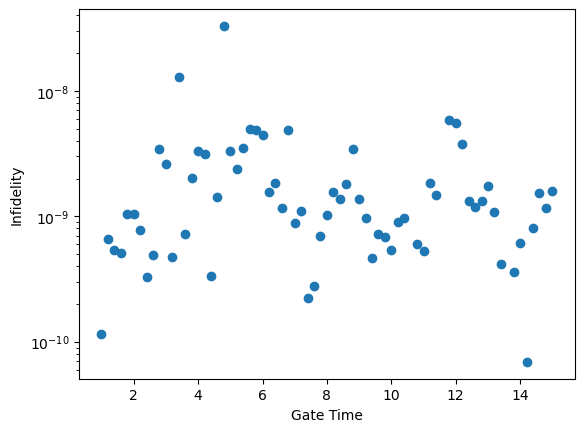

In [66]:
plt.semilogy(gate_times, fidelities, linestyle="", marker="o")
plt.xlabel("Gate Time")
plt.ylabel("Infidelity")

14.4


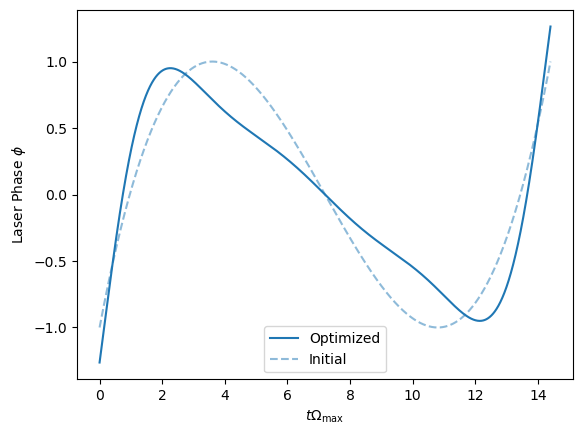

In [78]:
# plot (chebyshev) gate

iter_num = -4

print(gate_times[iter_num])

ts = np.linspace(0, gate_times[iter_num], 10001)
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("Laser Phase $\\phi$")
plt.plot(ts, chebyshev.chebval((2/gate_times[iter_num])*ts-1, goat_results[iter_num].x[:-1]), color="tab:blue", label="Optimized")
plt.plot(ts, chebyshev.chebval((2/gate_times[iter_num])*ts-1, alpha0), linestyle="--", alpha=0.5, label="Initial")
plt.legend()

plt.show()

In [72]:
# test results using QuTiP simulations
simulated_fidelities = np.zeros(n_times)

for i in range(n_times):
    chebyshev_drive_strength_func = lambda t: 1
    chebyshev_phase_func = lambda t: chebyshev.chebval((2/gate_times[i])*t-1, goat_results[i].x[:-1])

    results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, 100, 0, t_min, gate_times[i], 1001, plot=False)
    simulated_fidelities[i] = calculate_fidelity(results, single_qubit_phase=goat_results[i].x[-1])

    print(f"Gate Time: {gate_times[i]}, Fidelity: {simulated_fidelities[i]}")

Gate Time: 1.0, Fidelity: 0.39999999743338643
Gate Time: 1.2, Fidelity: 0.39999998785592733
Gate Time: 1.4, Fidelity: 0.4000000020946817
Gate Time: 1.6, Fidelity: 0.40000000633397764
Gate Time: 1.8, Fidelity: 0.39999996603694266
Gate Time: 2.0, Fidelity: 0.39999997375558943
Gate Time: 2.2, Fidelity: 0.4000000654153773
Gate Time: 2.4000000000000004, Fidelity: 0.4000046379105349
Gate Time: 2.6, Fidelity: 0.40000609955693656
Gate Time: 2.8, Fidelity: 0.3999999587877153
Gate Time: 3.0, Fidelity: 0.4000000267466886
Gate Time: 3.2, Fidelity: 0.4000201206516299
Gate Time: 3.4000000000000004, Fidelity: 0.3999984362489499
Gate Time: 3.6, Fidelity: 0.40013759028310547
Gate Time: 3.8000000000000003, Fidelity: 0.4000135996793365
Gate Time: 4.0, Fidelity: 0.40000307219903314
Gate Time: 4.2, Fidelity: 0.4000029991521527
Gate Time: 4.4, Fidelity: 0.40254414566144026
Gate Time: 4.6, Fidelity: 0.40003124913552973
Gate Time: 4.800000000000001, Fidelity: 0.39998829006005376
Gate Time: 5.0, Fidelity: 0.40

Text(0, 0.5, 'Simulated 1-F')

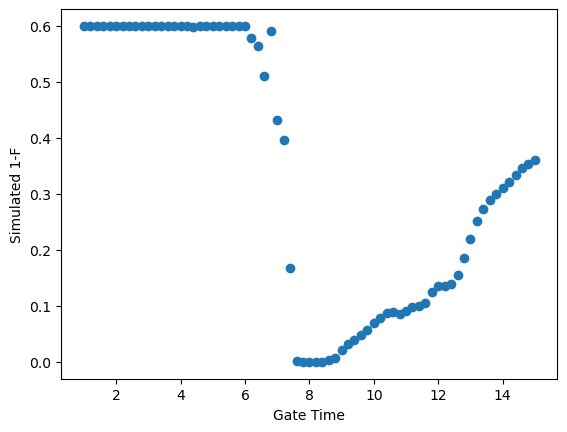

In [74]:
# plot simulated fidelities
plt.plot(gate_times, 1 - simulated_fidelities, linestyle="", marker="o")
plt.xlabel("Gate Time")
plt.ylabel("Simulated 1-F")

## Sweeping Number of Parameters

In [48]:
n_cheb_polys = np.arange(4, 81, 2)
n_iters = n_cheb_polys.size
goat_results = []
fidelities = np.zeros(n_iters)

control_funcs = [chebyshev_control_func_plus, chebyshev_control_func_minus]
control_param_derivs = chebyshev_control_param_derivs

t_min = 0
t_max = 7.612 # from TO gates paper 
t_span = [t_min, t_max]

control_extra_params = {
    "Omega_max": 1,
    "t_max": t_max
    # "n_pieces": n_pieces
}

optimizer_opts = {"maxiter": 400, "disp": False, "ftol": 1e-15, "gtol": 1e-15} # for L-BFGS-B

for i in range(n_iters):
    print(f"Number of Coefficients: {n_cheb_polys[i]}")
    alpha0 = np.zeros(n_cheb_polys[i] + 1)
    alpha0[3] = 1

    res = run_goat_optimization(
        H0,
        H_controls,
        control_funcs,
        control_param_derivs,
        alpha0,
        U_target,
        t_span,
        U_truncator,
        fidelity_func_name="GOAT",
        # alpha_bounds=alpha_bounds,
        constraints=chebyshev_constraint,
        single_qubit_phase_weights=[1, 2],
        control_extra_params=control_extra_params,
        optimizer_opts=optimizer_opts,
        callback=callback
    )

    goat_results.append(res)
    fidelities[i] = res.fun

Number of Coefficients: 4
Number of Coefficients: 6
Number of Coefficients: 8
Number of Coefficients: 10
Number of Coefficients: 12
Number of Coefficients: 14
Number of Coefficients: 16
Number of Coefficients: 18
Number of Coefficients: 20
Number of Coefficients: 22
Number of Coefficients: 24
Number of Coefficients: 26
Number of Coefficients: 28
Number of Coefficients: 30
Number of Coefficients: 32
Number of Coefficients: 34
Number of Coefficients: 36
Number of Coefficients: 38
Number of Coefficients: 40
Number of Coefficients: 42
Number of Coefficients: 44
Number of Coefficients: 46
Number of Coefficients: 48
Number of Coefficients: 50
Number of Coefficients: 52
Number of Coefficients: 54
Number of Coefficients: 56
Number of Coefficients: 58
Number of Coefficients: 60
Number of Coefficients: 62
Number of Coefficients: 64
Number of Coefficients: 66
Number of Coefficients: 68
Number of Coefficients: 70
Number of Coefficients: 72
Number of Coefficients: 74
Number of Coefficients: 76
Numb

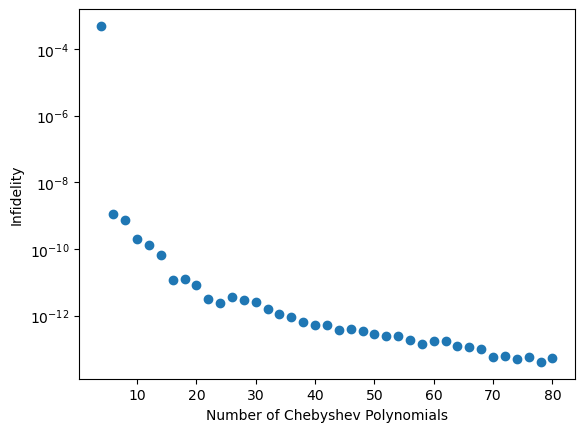

In [49]:
plt.semilogy(n_cheb_polys, fidelities, linestyle="", marker="o")
plt.xlabel("Number of Chebyshev Polynomials")
plt.ylabel("Infidelity")
plt.show()

50


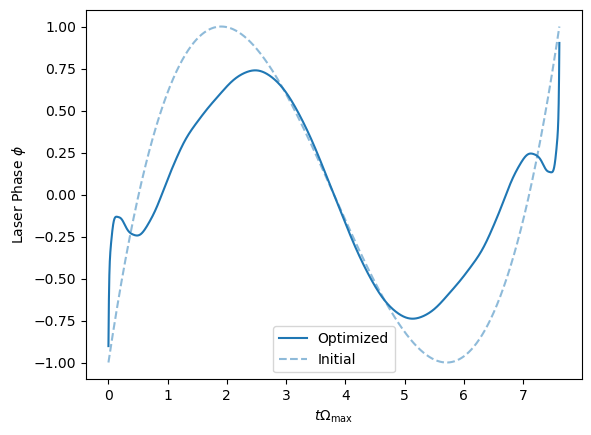

In [34]:
# plot (chebyshev) gate

iter_num = -1

print(n_cheb_polys[iter_num])

ts = np.linspace(0, t_max, 10001)
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("Laser Phase $\\phi$")
plt.plot(ts, chebyshev.chebval((2/t_max)*ts-1, goat_results[iter_num].x[:-1]), color="tab:blue", label="Optimized")
plt.plot(ts, chebyshev.chebval((2/t_max)*ts-1, alpha0), linestyle="--", alpha=0.5, label="Initial")
plt.legend()

plt.show()

In [50]:
# test results using QuTiP simulations
simulated_fidelities = np.zeros(n_iters)

for i in range(n_iters):
    chebyshev_drive_strength_func = lambda t: 1
    chebyshev_phase_func = lambda t: chebyshev.chebval((2/t_max)*t-1, goat_results[i].x[:-1])

    results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, 100, 0, t_min, t_max, 1001, plot=False)
    simulated_fidelities[i] = calculate_fidelity(results, single_qubit_phase=goat_results[i].x[-1])

    print(f"Number of Chebyshev Coefficients: {n_cheb_polys[i]}, Fidelity: {simulated_fidelities[i]}")

Number of Chebyshev Coefficients: 4, Fidelity: 0.7166987403650182
Number of Chebyshev Coefficients: 6, Fidelity: 0.995398725528855
Number of Chebyshev Coefficients: 8, Fidelity: 0.9999363093517175
Number of Chebyshev Coefficients: 10, Fidelity: 0.999797588397679
Number of Chebyshev Coefficients: 12, Fidelity: 0.9993123333806244
Number of Chebyshev Coefficients: 14, Fidelity: 0.9994805398583839
Number of Chebyshev Coefficients: 16, Fidelity: 0.9994847766509105
Number of Chebyshev Coefficients: 18, Fidelity: 0.9994922595342195
Number of Chebyshev Coefficients: 20, Fidelity: 0.9994861911794019
Number of Chebyshev Coefficients: 22, Fidelity: 0.9994942274686398
Number of Chebyshev Coefficients: 24, Fidelity: 0.9995013023034224
Number of Chebyshev Coefficients: 26, Fidelity: 0.9995086327428316
Number of Chebyshev Coefficients: 28, Fidelity: 0.9995114251889032
Number of Chebyshev Coefficients: 30, Fidelity: 0.999512611003579
Number of Chebyshev Coefficients: 32, Fidelity: 0.9995134201600617
N

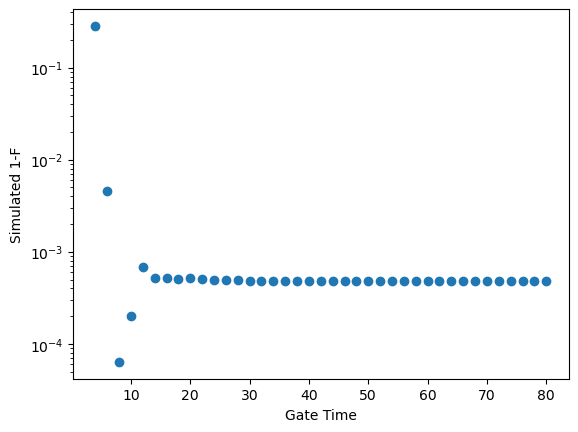

In [51]:
# plot simulated fidelities
plt.semilogy(n_cheb_polys, 1 - simulated_fidelities, linestyle="", marker="o")
plt.xlabel("Gate Time")
plt.ylabel("Simulated 1-F")
plt.show()

## Save Results

In [52]:
# save results
import pickle

# with open("results/goat_run_16.pkl", "wb") as f:
#     pickle.dump((res, prev_params), f)

with open("results/num_coefficients_sweep_2.pkl", "wb") as f:
    pickle.dump((n_cheb_polys, goat_results, fidelities), f)

In [ ]:
# exporting to pulse format for qutip simulations
with open("results/goat_run_13.pkl", "rb") as file:
    (loaded_res, loaded_prev_params) = pickle.load(file)

times = np.linspace(0, t_max, n_pieces)
phases = loaded_res.x[:-1]
Omegas = control_extra_params["Omega_max"] * np.ones(n_pieces)


np.savetxt("pulses/goat_gate4_best.csv", np.column_stack((times, Omegas, phases)), delimiter=",", header="t,|Omega|,arg(Omega)")